In [1]:
state = 'NE' 
year = 2020

In [2]:
filepath = 'C:\\dat\\'+str(year)+'\\'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [3]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NE has 3 districts.


In [4]:
#warm_starts = [[[0, 4, 8, 17, 43, 66, 73, 81, 93], [1, 9, 13, 14, 16, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 48, 49, 50, 52, 53, 55, 57, 58, 59, 62, 63, 64, 65, 68, 70, 74, 76, 78, 79, 84, 89, 91, 92], [5, 6, 7, 10, 11, 15, 29, 34, 45, 51, 61, 69, 75, 77, 80, 85, 88, 98], [2, 3, 12, 18, 24, 25, 26, 28, 38, 39, 44, 46, 47, 54, 56, 60, 67, 71, 72, 82, 83, 86, 87, 90, 94, 95, 96, 97]], [[3, 8, 12, 17, 38, 46, 48, 78, 93, 94, 95], [4, 6, 7, 10, 15, 16, 18, 29, 34, 36, 49, 50, 51, 56, 69, 75, 77, 83, 88], [0, 1, 2, 5, 9, 13, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 52, 53, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 74, 76, 79, 80, 81, 84, 86, 89, 91, 92, 96], [11, 24, 25, 26, 28, 39, 44, 45, 47, 54, 61, 67, 72, 82, 85, 87, 90, 97, 98]], [[4, 8, 17, 30, 32, 35, 37, 40, 43, 49, 52, 64, 66, 70, 73, 89], [1, 2, 9, 12, 14, 19, 20, 21, 22, 23, 26, 27, 31, 33, 38, 41, 42, 46, 53, 55, 58, 59, 60, 62, 63, 65, 68, 71, 76, 78, 79, 84, 86, 91, 92, 93, 96, 97], [0, 5, 6, 10, 13, 16, 18, 29, 34, 36, 45, 48, 50, 51, 57, 69, 74, 75, 77, 80, 81, 85, 88, 94, 95], [3, 7, 11, 15, 24, 25, 28, 39, 44, 47, 54, 56, 61, 67, 72, 82, 83, 87, 90, 98]], [[4, 8, 10, 17, 37, 53, 62, 93], [0, 1, 2, 9, 12, 14, 16, 18, 20, 21, 22, 23, 26, 27, 31, 33, 38, 41, 42, 43, 46, 48, 49, 50, 58, 59, 60, 63, 65, 66, 68, 71, 73, 76, 78, 79, 84, 86, 92, 94, 95, 96, 97], [5, 6, 13, 19, 29, 30, 32, 34, 35, 36, 40, 45, 51, 52, 55, 57, 64, 69, 70, 74, 75, 77, 80, 81, 85, 88, 89, 91], [3, 7, 11, 15, 24, 25, 28, 39, 44, 47, 54, 56, 61, 67, 72, 82, 83, 87, 90, 98]], [[2, 8, 21, 22, 27, 48, 53, 60, 68, 71, 76, 78, 79, 92, 93, 94], [0, 5, 7, 11, 13, 15, 30, 32, 34, 35, 36, 40, 43, 50, 52, 56, 57, 64, 69, 70, 72, 74, 77, 80, 81, 82, 87, 88, 89, 90, 91], [1, 4, 6, 9, 14, 16, 17, 19, 20, 23, 29, 31, 33, 37, 41, 42, 49, 51, 55, 58, 59, 62, 63, 65, 66, 73, 75, 84], [3, 10, 12, 18, 24, 25, 26, 28, 38, 39, 44, 45, 46, 47, 54, 61, 67, 83, 85, 86, 95, 96, 97, 98]], [[4, 8, 10, 17, 37, 53, 62, 93], [0, 1, 2, 6, 9, 14, 16, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 40, 41, 42, 43, 48, 49, 50, 52, 55, 58, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 76, 78, 79, 81, 84, 89, 91, 92], [3, 18, 28, 34, 38, 45, 46, 54, 67, 75, 83, 85, 88, 94, 95, 98], [5, 7, 11, 12, 13, 15, 24, 25, 26, 29, 36, 39, 44, 47, 51, 56, 57, 61, 69, 72, 74, 77, 80, 82, 86, 87, 90, 96, 97]], [[4, 8, 10, 17, 37, 53, 62, 93], [6, 15, 25, 28, 34, 45, 47, 61, 72, 83, 85, 88, 98], [0, 5, 7, 11, 13, 16, 19, 29, 30, 32, 35, 36, 40, 43, 49, 50, 51, 52, 55, 56, 57, 63, 64, 66, 69, 70, 73, 74, 75, 77, 80, 81, 82, 87, 89, 90, 91], [1, 2, 3, 9, 12, 14, 18, 20, 21, 22, 23, 24, 26, 27, 31, 33, 38, 39, 41, 42, 44, 46, 48, 54, 58, 59, 60, 65, 67, 68, 71, 76, 78, 79, 84, 86, 92, 94, 95, 96, 97]], [[4, 8, 10, 17, 18, 46, 48, 78, 94], [3, 12, 24, 25, 26, 38, 39, 44, 47, 54, 60, 67, 68, 71, 72, 76, 86, 87, 93, 96, 97, 98], [6, 7, 11, 13, 15, 28, 29, 34, 45, 51, 56, 61, 69, 75, 77, 80, 82, 83, 85, 88, 90, 95], [0, 1, 2, 5, 9, 14, 16, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 43, 49, 50, 52, 53, 55, 57, 58, 59, 62, 63, 64, 65, 66, 70, 73, 74, 79, 81, 84, 89, 91, 92]], [[2, 8, 10, 16, 18, 38, 46, 48, 60, 68, 71, 76, 78, 94, 95], [0, 1, 4, 9, 14, 17, 19, 20, 21, 22, 23, 27, 31, 33, 37, 41, 42, 43, 49, 50, 52, 53, 55, 58, 59, 62, 65, 66, 73, 79, 84, 92, 93], [5, 6, 7, 11, 13, 29, 30, 32, 34, 35, 36, 40, 45, 51, 56, 57, 63, 64, 69, 70, 74, 75, 77, 80, 81, 85, 88, 89, 90, 91], [3, 12, 15, 24, 25, 26, 28, 39, 44, 47, 54, 61, 67, 72, 82, 83, 86, 87, 96, 97, 98]], [[2, 8, 12, 21, 22, 41, 46, 48, 60, 68, 71, 76, 78, 86, 93, 94, 96], [6, 7, 11, 15, 29, 34, 45, 50, 51, 56, 61, 72, 75, 77, 82, 83, 85, 87, 88, 90], [3, 4, 10, 16, 18, 24, 25, 26, 28, 38, 39, 44, 47, 54, 67, 95, 97, 98], [0, 1, 5, 9, 13, 14, 17, 19, 20, 23, 27, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 49, 52, 53, 55, 57, 58, 59, 62, 63, 64, 65, 66, 69, 70, 73, 74, 79, 80, 81, 84, 89, 91, 92]], [[2, 3, 8, 12, 38, 46, 48, 54, 60, 67, 68, 71, 76, 78, 83, 86, 94, 95, 96], [15, 24, 25, 26, 39, 44, 47, 61, 72, 88, 97, 98], [4, 5, 6, 7, 10, 11, 13, 16, 18, 28, 29, 34, 36, 45, 51, 56, 57, 64, 69, 74, 75, 77, 80, 81, 82, 85, 87, 90], [0, 1, 9, 14, 17, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 49, 50, 52, 53, 55, 58, 59, 62, 63, 65, 66, 70, 73, 79, 84, 89, 91, 92, 93]], [[1, 2, 8, 20, 21, 22, 27, 41, 53, 59, 60, 71, 79, 92, 93], [3, 12, 24, 25, 26, 28, 38, 39, 44, 46, 47, 48, 54, 61, 67, 68, 76, 78, 83, 86, 94, 95, 96, 97, 98], [0, 4, 5, 9, 10, 14, 16, 17, 18, 19, 23, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 49, 52, 55, 57, 58, 62, 63, 64, 65, 66, 70, 73, 74, 81, 84, 89, 91], [6, 7, 11, 13, 15, 29, 34, 45, 50, 51, 56, 69, 72, 75, 77, 80, 82, 85, 87, 88, 90]], [[4, 6, 8, 10, 16, 18, 93], [5, 7, 11, 13, 15, 34, 45, 51, 56, 61, 69, 72, 74, 75, 77, 80, 82, 85, 87, 88, 90], [3, 12, 21, 24, 25, 26, 28, 38, 39, 44, 46, 47, 48, 54, 60, 67, 68, 71, 76, 78, 83, 86, 94, 95, 96, 97, 98], [0, 1, 2, 9, 14, 17, 19, 20, 22, 23, 27, 29, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 43, 49, 50, 52, 53, 55, 57, 58, 59, 62, 63, 64, 65, 66, 70, 73, 79, 81, 84, 89, 91, 92]], [[4, 6, 8, 10, 16, 18, 93], [5, 7, 11, 13, 15, 29, 34, 50, 51, 56, 61, 69, 72, 75, 77, 80, 82, 85, 87, 88, 90], [3, 12, 21, 24, 25, 26, 28, 38, 39, 44, 45, 46, 47, 48, 54, 60, 67, 71, 76, 78, 83, 86, 94, 95, 96, 97, 98], [0, 1, 2, 9, 14, 17, 19, 20, 22, 23, 27, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 43, 49, 52, 53, 55, 57, 58, 59, 62, 63, 64, 65, 66, 68, 70, 73, 74, 79, 81, 84, 89, 91, 92]], [[1, 2, 8, 14, 20, 21, 22, 27, 41, 59, 60, 65, 68, 71, 76, 78, 79, 84, 92], [0, 4, 9, 16, 17, 19, 23, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 49, 50, 52, 53, 55, 57, 58, 62, 63, 64, 66, 70, 73, 74, 81, 89, 91, 93], [3, 6, 10, 12, 13, 18, 24, 26, 28, 29, 34, 38, 39, 44, 45, 46, 48, 54, 67, 75, 83, 85, 86, 94, 95, 96, 97, 98], [5, 7, 11, 15, 25, 47, 51, 56, 61, 69, 72, 77, 80, 82, 87, 88, 90]], [[0, 4, 8, 10, 16, 17, 18, 43, 49, 50, 66], [1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 52, 53, 55, 57, 58, 59, 60, 62, 63, 64, 65, 70, 71, 73, 74, 79, 81, 84, 89, 91, 92, 93], [3, 12, 24, 25, 26, 28, 38, 39, 44, 46, 47, 48, 54, 61, 67, 68, 76, 78, 83, 86, 94, 95, 96, 97, 98], [5, 6, 7, 11, 13, 15, 29, 34, 45, 51, 56, 69, 72, 75, 77, 80, 82, 85, 87, 88, 90]], [[1, 2, 8, 14, 20, 21, 22, 27, 41, 59, 60, 65, 68, 71, 76, 78, 79, 84, 92], [3, 10, 12, 18, 24, 25, 26, 28, 38, 39, 44, 46, 47, 48, 54, 61, 67, 83, 86, 94, 95, 96, 97, 98], [0, 4, 9, 16, 17, 19, 23, 30, 31, 32, 33, 35, 36, 37, 40, 42, 43, 49, 50, 52, 53, 55, 57, 58, 62, 63, 64, 66, 70, 73, 74, 81, 89, 91, 93], [5, 6, 7, 11, 13, 15, 29, 34, 45, 51, 56, 69, 72, 75, 77, 80, 82, 85, 87, 88, 90]], [[4, 6, 8, 10, 16, 17, 49, 93], [5, 7, 11, 13, 15, 29, 34, 36, 45, 50, 51, 56, 69, 74, 75, 77, 80, 82, 85, 87, 88, 90], [3, 12, 18, 24, 25, 26, 28, 38, 39, 44, 46, 47, 54, 61, 67, 72, 83, 86, 94, 95, 96, 97, 98], [0, 1, 2, 9, 14, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 35, 37, 40, 41, 42, 43, 48, 52, 53, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 70, 71, 73, 76, 78, 79, 81, 84, 89, 91, 92]]]

In [5]:
obj_type = 'cut_edges'
starting_deviation = 0.01 
verbose = True
contiguity = 'lcut'               # {'lcut', 'scf', 'shir'}
warm_start_mode = 'user'          # {'None', 'user', 'refinement'}
warm_starts = None                # if you have user define warm strats else it is None
time_limit = 7200                 # Time limit in seconds, adjust as needed
multiplier = 0                    # Adjust multiplier as needed
max_B = True                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True
symmetry_breaking = 'orbitope'    # {None, 'orbitope', 'rsum'}              
sizes = None

In [6]:
print(f"Running epsilon constraint method for state {state}, objective {obj_type}")
print(f"{'#' * 100}\n")
(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity,        
            cutoff=None,       
            verbose=verbose,
            warm_start_mode = warm_start_mode,
            warm_starts=warm_starts,  
            starting_deviation=starting_deviation, 
            time_limit=time_limit, 
            sizes=sizes,      
            max_B=max_B,      
            symmetry_breaking=symmetry_breaking, 
        )

Running epsilon constraint method for state NE, objective cut_edges
####################################################################################################

L = 647297 and U = 660373

****************************************
Trying deviation = 6538.346666666666
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 647297 and U = 660373
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (

Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0x686f7f04
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1965 rows and 1401 columns
Presolve time: 0.02s
Presolved: 1839 rows, 1842 columns, 6404 nonzeros
Variable types: 0

Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0xb43763db
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1954 rows and 1393 columns
Presolve time: 0.03s
Presolved: 1850 rows, 1850 columns, 6444 nonzeros
Variable types: 0

Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 3804 rows, 3243 columns and 12403 nonzeros
Model fingerprint: 0x2fe3d3dd
Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1986 rows and 1409 columns
Presolve time: 0.02s
Presolved: 1818 rows, 1834 columns, 6332 nonzeros
Variable types: 0


User-callback calls 12268, time in user-callback 1.90 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[9, 10, 26, 43, 44, 76], [6, 7, 19, 21, 28, 33, 47, 48, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92]]

****************************************
Trying deviation = 492.4999999999612
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 653343 and U = 654327
sizes =  [1, 1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Se

Thread count was 20 (of 20 available processors)

Solution count 3: 25 35 36 

Optimal solution found (tolerance 0.00e+00)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 55993, time in user-callback 4.15 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[10, 21, 26, 44, 76], [6, 7, 19, 20, 28, 33, 47, 48, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92]]

****************************************
Trying deviation = 187.4999999999612
****************************************
No valid warm start used.

****************************************
Running labeling model!
***********************************

     0     0   12.91804    0  283          -   12.91804      -     -    0s
     0     0   13.23089    0  236          -   13.23089      -     -    0s
     0     0   13.30674    0  275          -   13.30674      -     -    0s
     0     0   13.30790    0  275          -   13.30790      -     -    0s
     0     0   13.30860    0  279          -   13.30860      -     -    0s
     0     0   13.32264    0  278          -   13.32264      -     -    1s
     0     0   13.33546    0  275          -   13.33546      -     -    1s
     0     0   13.33622    0  278          -   13.33622      -     -    1s
     0     0   13.48565    0  248          -   13.48565      -     -    1s
     0     0   13.51249    0  279          -   13.51249      -     -    1s
     0     0   13.51249    0  279          -   13.51249      -     -    1s
     0     0   13.57244    0  357          -   13.57244      -     -    1s
     0     0   13.57339    0  359          -   13.57339      -     -    1s
     0     0   13.59857  

Variable types: 837 continuous, 2406 integer (2406 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 1993 rows and 1411 columns
Presolve time: 0.02s
Presolved: 1811 rows, 1832 columns, 6307 nonzeros
Variable types: 0 continuous, 1832 integer (1832 binary)

Root relaxation: objective 1.176049e+01, 1960 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.76049    0  255          -   11.76049      -     -    0s
     0     0   12.97976    0  305          -   12.97976      -     -    0s
     0     0   13.31244    0  250          -   13.31244      -     -    0s
     0     0   13.42280    0  300          -   13.42280      -     -    0s
     0     0   13.42356    0  302          -   13.42356      -     

     0     0   11.12854    0  421          -   11.12854      -     -    1s
     0     0   11.12901    0  415          -   11.12901      -     -    1s
     0     0   11.12901    0  463          -   11.12901      -     -    1s
     0     0   11.13075    0  463          -   11.13075      -     -    1s
     0     2   11.14473    0  418          -   11.14473      -     -    1s
  1758  1535   33.69950   21  345          -   14.88664      -  70.7    5s
  3160  2329   23.15871   39   93          -   16.11943      -  83.0   10s
  8596  5245   33.42367   31  331          -   17.74393      -  69.0   15s
 14670  9270   29.21137   30  157          -   20.70641      -  61.6   20s
 21256 13418   37.14120   38  183          -   21.51210      -  60.1   25s
 28067 17136   28.11859   26  177          -   23.45103      -  60.8   31s
 32626 19631   32.16464   46  281          -   24.26784      -  62.4   35s
 39474 22151   32.77535   25  293          -   25.33927      -  65.3   41s
 42884 23596   33.09465  

 40599 26581   66.30708   70   30          -   22.41456      -  79.9   35s
 46050 29136 infeasible   39               -   22.86149      -  81.4   40s
 52658 32992 infeasible   46               -   23.27019      -  83.0   46s
 57211 35465   31.34226   30  272          -   23.73985      -  84.7   50s
 62961 38027   30.67589   27  289          -   24.28267      -  85.7   56s
 67904 40595   37.72194   36  421          -   25.01771      -  87.2   60s
 73589 42914   39.66777   32  119          -   25.43936      -  88.5   65s
 77887 44668 infeasible   67               -   25.90646      -  89.0   71s
 83971 47366   40.99198   38  165          -   26.54982      -  89.8   76s
 89188 49215   40.16573   52  102          -   26.94755      -  91.1   81s
 94652 51299   37.99752   30  183          -   27.39790      -  92.0   86s
 100042 52828   32.19988   27  305          -   27.85977      -  93.0   90s
 104778 54874 infeasible   30               -   28.27541      -  94.0   96s
 108967 55811   36.2176


Cutting planes:
  Gomory: 6
  Cover: 286
  Implied bound: 1
  Clique: 1
  MIR: 9
  StrongCG: 3
  Inf proof: 46
  Zero half: 6
  RLT: 16
  Lazy constraints: 1108

Explored 370049 nodes (35455596 simplex iterations) in 567.15 seconds (227.54 work units)
Thread count was 20 (of 20 available processors)

Solution count 4: 45 51 52 61 

Optimal solution found (tolerance 0.00e+00)
Best objective 4.500000000000e+01, best bound 4.500000000000e+01, gap 0.0000%

User-callback calls 777340, time in user-callback 15.36 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[4, 16, 40, 44, 59, 72, 76, 81], [7, 10, 20, 21, 36, 37, 47, 61], [0, 1, 2, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 41, 42, 43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90

 181477 89185   60.15966   65   64          -   32.43944      -  92.5  305s
 184639 90293   34.66138   39  152          -   32.59728      -  92.8  311s
 186301 90376   50.23878   30  105          -   32.72017      -  93.0  315s
 188226 91501 infeasible   48               -   32.82535      -  93.2  321s
 191796 92858   35.80116   43  223          -   32.98872      -  93.3  327s
 193560 93440   48.74197   45  185          -   33.07239      -  93.4  330s
 196679 94616   37.80471   47  285          -   33.20174      -  93.7  336s
 200262 95401 infeasible   30               -   33.40230      -  93.9  342s
 201858 95910   40.53212   48  232          -   33.45709      -  94.1  345s
*204766 82655              73      65.0000000   33.58689  48.3%  94.2  348s
 205535 82930 infeasible   38        65.00000   33.65406  48.2%  94.1  352s
 207158 83211   45.54664   38  218   65.00000   33.74359  48.1%  94.2  356s
 210243 83711   41.07710   47  156   65.00000   33.99424  47.7%  94.3  362s
H210480 6683

  2801  2109   35.79822   31   82          -   15.93431      -  92.0   15s
  5190  3278   23.06549   45   22          -   15.93431      -  77.0   20s
  7846  4635   63.00000   77    8          -   15.93431      -  71.1   25s
 12056  7805   29.20106   45  152          -   18.35474      -  66.2   30s
 14679  9435 infeasible   48               -   18.91688      -  66.0   35s
 18390 11769   42.37270   45  181          -   19.19165      -  64.8   40s
 23289 14372   25.85099   39  157          -   19.90918      -  63.3   47s
 24809 15688   35.89086   32  168          -   20.19072      -  63.1   50s
 28700 18045 infeasible   51               -   21.22187      -  62.5   56s
 32056 19928   25.77419   34  193          -   21.43060      -  62.6   62s
 35062 21693   44.68089   59   90          -   22.12114      -  62.4   66s
 38283 22803   26.49524   23  349          -   22.45836      -  62.2   72s
 38524 23801   33.51451   30  248          -   22.64709      -  62.5   75s
 41812 25765   52.09970  

 267647 25146   43.19644   30  113   49.00000   41.78983  14.7%  77.4  564s
 269779 24833   42.91028   39   63   49.00000   41.94483  14.4%  77.4  569s
 272021 24311   42.92004   35  298   49.00000   42.05433  14.2%  77.3  573s
 274239 23794   43.68960   31   89   49.00000   42.20398  13.9%  77.1  578s
 276345 23297   47.61041   30  194   49.00000   42.35867  13.6%  77.1  583s
 278610 22833 infeasible   32        49.00000   42.53463  13.2%  76.9  588s
 280670 22330 infeasible   31        49.00000   42.69244  12.9%  76.9  593s
 282799 21907 infeasible   36        49.00000   42.80568  12.6%  76.8  598s
H284696 10678                      46.0000000   42.81897  6.92%  76.7  598s
 285010  9297     cutoff   56        46.00000   42.97559  6.57%  76.6  601s
 286726  8487     cutoff   29        46.00000   43.24521  5.99%  76.4  605s
 291080  4089 infeasible   34        46.00000   43.96180  4.43%  75.8  613s
 294542   204     cutoff   39        46.00000   44.56449  3.12%  75.1  616s

Cutting pla

 219553 121573 infeasible   41               -   27.49418      -  76.0  256s
 223621 123318   37.00000   49   40          -   27.58384      -  76.1  260s
 229727 125375   31.27034   30  313          -   27.75296      -  76.1  265s
 230961 126708 infeasible   31               -   27.86249      -  76.1  270s
 235044 128565   42.02362   38  313          -   27.95914      -  76.1  275s
 241184 131906   55.90037   47   45          -   28.10774      -  76.2  281s
 246022 133668   38.39332   38  358          -   28.24164      -  76.1  286s
 249819 135084   65.45879   55  139          -   28.30943      -  76.2  290s
 253365 136212   38.02121   27  364          -   28.41889      -  76.4  295s
 256021 137564   43.67288   33  335          -   28.49659      -  76.5  300s
 261428 139812   31.01261   29  323          -   28.66303      -  76.7  306s
 265140 141402 infeasible   40               -   28.76518      -  76.8  311s
 269204 142583   48.25158   37  190          -   28.90100      -  76.9  315s

 579299 222074   41.24299   39  318          -   38.07746      -  85.3  790s
 582889 222986   46.11547   36  211          -   38.14788      -  85.3  795s
 586449 223844   50.32244   46  232          -   38.20805      -  85.3  801s
 590042 225061   57.15647   51  143          -   38.28646      -  85.3  806s
 593759 226175   58.28652   49  184          -   38.33481      -  85.3  812s
 595735 226759   46.88516   44  197          -   38.38326      -  85.3  815s
 599818 227756   53.76509   34  184          -   38.46531      -  85.2  820s
 602400 228288   55.71090   45  212          -   38.50258      -  85.2  827s
 604054 228836   60.27833   44  204          -   38.55300      -  85.2  830s
 607663 229599   51.03260   41  213          -   38.60259      -  85.2  835s
 611554 230610 infeasible   49               -   38.68235      -  85.2  841s
 615149 231806   67.16343   64  179          -   38.74607      -  85.2  847s
 617302 232100 infeasible   40               -   38.80948      -  85.2  850s

 841645 112580   45.78960   35  458   54.00000   43.13448  20.1%  85.1 1327s
 844009 112263 infeasible   40        54.00000   43.19193  20.0%  85.0 1332s
 846329 112001 infeasible   38        54.00000   43.28050  19.9%  85.0 1338s
 848585 111641     cutoff   35        54.00000   43.33276  19.8%  85.0 1342s
 850946 111400   44.31862   38  348   54.00000   43.40020  19.6%  85.0 1347s
 853134 111122   48.29973   42  222   54.00000   43.45828  19.5%  85.0 1352s
 855207 110829   45.28230   36  360   54.00000   43.50363  19.4%  85.0 1357s
 857493 110459 infeasible   55        54.00000   43.55762  19.3%  85.0 1361s
 859614 110168   47.52500   40  193   54.00000   43.63051  19.2%  85.0 1366s
 861793 109842   48.25053   31  429   54.00000   43.70199  19.1%  85.0 1371s
 863851 109469   50.34280   45   68   54.00000   43.75024  19.0%  85.0 1376s
 866046 109117   51.71160   35  231   54.00000   43.81413  18.9%  85.0 1381s
 868219 108798 infeasible   53        54.00000   43.88676  18.7%  85.0 1385s

 1077530 69392   52.72382   36  345   54.00000   48.37082  10.4%  82.6 1869s
 1079624 68752 infeasible   45        54.00000   48.42118  10.3%  82.6 1873s
 1081735 68068 infeasible   43        54.00000   48.46124  10.3%  82.5 1878s
H1082613 27791                      51.0000000   48.46491  4.97%  82.5 1878s
 1083708 26995     cutoff   39        51.00000   48.50786  4.89%  82.5 1881s
 1086027 23975 infeasible   59        51.00000   48.52869  4.85%  82.4 1887s
 1087998 22054 infeasible   39        51.00000   48.73443  4.44%  82.3 1890s
 1092398 17624     cutoff   50        51.00000   48.96808  3.98%  82.1 1896s
*1092559     0              47      50.0000000   48.96811  2.06%  82.1 1896s

Cutting planes:
  Gomory: 5
  Cover: 675
  MIR: 3
  Flow cover: 5
  Inf proof: 71
  Zero half: 11
  RLT: 13
  Lazy constraints: 1067

Explored 1094966 nodes (89713221 simplex iterations) in 1898.41 seconds (538.92 work units)
Thread count was 20 (of 20 available processors)

Solution count 4: 50 51 54 55 

 211148 112063   45.05993   43  240          -   28.65607      -  72.8  205s
 214356 112836   39.25208   36  295          -   28.80502      -  73.2  210s
 219686 113872   37.25661   26  286          -   29.28563      -  73.6  216s
 223266 114334   49.29989   37  105          -   29.45015      -  73.8  220s
 227940 115187   41.80399   30  259          -   29.74611      -  74.2  225s
 232888 116108   38.18881   37   53          -   30.01853      -  74.5  231s
 234406 116152 infeasible   48               -   30.13551      -  74.7  236s
 236102 116777   38.88743   33  162          -   30.21715      -  74.8  240s
 241205 117533 infeasible   41               -   30.45996      -  75.1  245s
 246470 118414   47.59207   39  166          -   30.72933      -  75.3  251s
 250156 119073   41.34245   28  269          -   30.94728      -  75.4  255s
 255354 120163   37.34292   26  375          -   31.15190      -  75.6  261s
 258843 120743 infeasible   36               -   31.34533      -  75.7  265s

 565261 191275   45.11041   41  157          -   40.79540      -  75.5  740s
 568992 192276   48.07666   67   88          -   40.85101      -  75.5  747s
 570678 192897   46.93094   39   82          -   40.89947      -  75.5  750s
 574472 193902   57.76983   35  239          -   40.97084      -  75.4  756s
 576345 194430   49.17415   39  100          -   40.99200      -  75.4  760s
 580057 195587   62.57399   52   86          -   41.04636      -  75.4  766s
 582027 196001 infeasible   56               -   41.08401      -  75.4  770s
 586037 196969   44.71771   45  192          -   41.16077      -  75.3  777s
 587864 197472   59.50003   56   51          -   41.19912      -  75.3  780s
 592017 198396   47.99753   34  274          -   41.27585      -  75.2  786s
 593764 198976   59.20242   61  179          -   41.30097      -  75.2  790s
 597727 199967 infeasible   46               -   41.35600      -  75.2  797s
 599775 200404   45.99827   52   47          -   41.39312      -  75.1  802s

 856511 279769   52.23467   37  155          -   44.71276      -  72.0 1281s
 860402 280990   47.91622   45  319          -   44.76378      -  72.0 1288s
 862448 281635   62.65279   76  145          -   44.79913      -  71.9 1291s
 864487 282249 infeasible   35               -   44.80893      -  71.9 1295s
 866460 282587   61.36457   44  144          -   44.83414      -  71.9 1300s
 869354 283896   49.14949   73   52          -   44.85834      -  71.9 1307s
 871302 284543   60.78188   34  310          -   44.87455      -  71.8 1310s
 875381 285809   54.45072   46  110          -   44.92014      -  71.8 1318s
 877307 286434   52.04824   57  190          -   44.93713      -  71.8 1321s
 879172 287009   46.98890   32  307          -   44.96061      -  71.8 1325s
 883579 288534 infeasible   33               -   44.99942      -  71.7 1333s
 885669 288874   52.09328   40  282          -   45.00356      -  71.7 1338s
 886524 289591   57.21017   47   34          -   45.00763      -  71.6 1341s

 1101108 364345   69.06061   44  244          -   46.71429      -  69.5 1817s
 1102747 365006   61.17441   58  105          -   46.72400      -  69.4 1821s
 1106416 365749 infeasible   58               -   46.75009      -  69.4 1832s
 1106598 366615   60.80867   78  102          -   46.75711      -  69.4 1836s
 1108608 367337 infeasible   42               -   46.77036      -  69.4 1840s
 1112197 368498   55.72581   55  102          -   46.79704      -  69.4 1848s
 1113911 369044   52.12732   49  350          -   46.80724      -  69.4 1852s
 1115762 369672   61.76101   35  317          -   46.82648      -  69.4 1856s
 1117523 370479   56.83894   33  280          -   46.83757      -  69.4 1860s
 1121271 371699   54.35268   35  310          -   46.86507      -  69.3 1868s
 1122975 372362 infeasible   43               -   46.88249      -  69.3 1872s
 1124823 373092   75.88540   53   82          -   46.89986      -  69.3 1876s
 1126617 373729 infeasible   68               -   46.91180      

Variable types: 0 continuous, 1832 integer (1832 binary)

Root relaxation: objective 1.176762e+01, 1987 iterations, 0.08 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.76762    0  255          -   11.76762      -     -    0s
     0     0   12.91714    0  234          -   12.91714      -     -    0s
     0     0   13.24309    0  280          -   13.24309      -     -    0s
     0     0   13.38968    0  347          -   13.38968      -     -    0s
     0     0   13.39000    0  348          -   13.39000      -     -    0s
     0     0   13.40043    0  290          -   13.40043      -     -    0s
     0     0   13.40043    0  289          -   13.40043      -     -    0s
     0     2   13.40118    0  289          -   13.40118      -     -    0s
  1819  1648   19.53643   17  263          -   14.76422      -  78.7    5s
  4581  3272   22.94168   

 546705 282298 infeasible   46               -   29.48402      -  73.6  485s
 552980 284584 infeasible   49               -   29.55818      -  73.6  491s
 556831 286384 infeasible   70               -   29.61699      -  73.6  495s
 562837 288062 infeasible   40               -   29.72645      -  73.7  501s
 568518 290027   32.52422   32  226          -   29.80688      -  73.7  506s
 571858 290898   50.71968   36  134          -   29.86072      -  73.8  511s
 575450 292201   35.22699   41   67          -   29.92911      -  73.8  515s
 580549 293995 infeasible   40               -   30.03577      -  73.9  520s
 582484 294697   53.82650   47  181          -   30.04499      -  73.9  526s
 586268 296019   40.44760   21  375          -   30.12759      -  74.0  530s
 591879 297841   35.10612   27  356          -   30.21872      -  74.0  536s
 595473 299146   37.43685   51  212          -   30.28468      -  74.1  540s
 601154 300920   57.82531   32  381          -   30.38749      -  74.1  545s

 983499 378354   57.65485   33  262          -   37.12198      -  76.9 1026s
 987335 379020   49.18867   48  238          -   37.18535      -  76.9 1031s
 990943 379447   42.84987   32  339          -   37.25096      -  76.9 1035s
 994538 380045   88.50195   45  390          -   37.31151      -  76.9 1040s
 998351 380909   61.34410   56  123          -   37.36192      -  76.9 1045s
 1002093 381508 infeasible   34               -   37.43022      -  76.9 1050s
 1005609 381942 infeasible   45               -   37.48445      -  76.9 1055s
 1008670 382490   50.66169   43  222          -   37.52527      -  76.9 1061s
 1012350 383394   41.67532   27  345          -   37.58097      -  77.0 1066s
 1016148 384058   77.40613   63   57          -   37.64539      -  77.0 1071s
 1017890 384137   52.35784   36  515          -   37.65928      -  77.0 1075s
 1020404 385046   64.49615   62   46          -   37.68909      -  77.0 1080s
 1024069 385950   41.68473   34  274          -   37.74774      -  77

 1305948 445450   79.10210   85   39          -   40.94441      -  77.4 1556s
 1309632 446493   54.89906   42   79          -   40.97928      -  77.4 1562s
 1311569 447072   44.82190   56  163          -   40.99645      -  77.4 1565s
 1315092 447819 infeasible   40               -   41.01882      -  77.4 1571s
 1318524 448660   46.73695   48  442          -   41.05400      -  77.4 1576s
 1321954 449118   56.07316   57  258          -   41.09583      -  77.4 1584s
 1322483 449435 infeasible   64               -   41.09700      -  77.4 1587s
 1324228 449765   55.73119   63  175          -   41.10822      -  77.4 1590s
 1327687 450569 infeasible   35               -   41.13656      -  77.5 1595s
 1331047 451563   49.51563   54  147          -   41.17680      -  77.5 1601s
 1334716 452328   51.95567   46  218          -   41.20516      -  77.5 1607s
 1336374 452816   53.42341   59  116          -   41.21576      -  77.5 1610s
 1339998 453649   53.96832   43  285          -   41.25031      

 1576524 514355   47.65791   41   60          -   43.10784      -  77.8 2101s
 1579679 514920   58.32811   40  190          -   43.12014      -  77.8 2105s
 1581702 515835   61.58157   51  258          -   43.14295      -  77.8 2111s
 1583542 516299 infeasible   51               -   43.15068      -  77.8 2115s
 1585504 516458 infeasible   40               -   43.16847      -  77.8 2121s
 1587897 517548   68.99243   60   38          -   43.18365      -  77.8 2128s
 1589717 517938 infeasible  106               -   43.19215      -  77.8 2131s
 1593010 518680   53.03713   43  268          -   43.21613      -  77.8 2138s
 1594692 519113   44.32406   38  181          -   43.22550      -  77.8 2141s
 1596443 519584   52.93992   44  308          -   43.23638      -  77.8 2145s
 1599963 520546 infeasible   43               -   43.25666      -  77.8 2152s
 1601670 520889   53.11129   40  133          -   43.27354      -  77.8 2155s
 1604814 521347   49.10021   33  223          -   43.29411      

 1810118 581587   47.38313   37  184          -   44.52086      -  78.2 2650s
 1813450 582564   54.99047   34  317          -   44.53881      -  78.2 2657s
 1814981 583121   57.03219   38  354          -   44.54976      -  78.2 2661s
 1816594 583417   54.58332   43  315          -   44.55595      -  78.2 2666s
 1817565 583974 infeasible   35               -   44.56371      -  78.2 2670s
 1820729 584975   54.47806   58  162          -   44.58080      -  78.2 2678s
 1822469 585394   48.97885   39  255          -   44.58869      -  78.2 2681s
 1824113 585854   71.92568   51  152          -   44.59983      -  78.2 2685s
 1827452 586790   50.08551   43  195          -   44.61866      -  78.2 2692s
 1828973 587436   60.75000   64  260          -   44.62416      -  78.2 2696s
 1830775 587760   51.64545   48  141          -   44.63391      -  78.2 2702s
 1831764 588307   59.82097   63   84          -   44.63790      -  78.2 2705s
 1835065 588819   64.83847   57  116          -   44.65353      

 2012356 644158   56.94720   57  316          -   45.53704      -  78.4 3223s
 2013984 644622 infeasible   31               -   45.54837      -  78.4 3227s
 2015545 644978   60.35217   42  268          -   45.55358      -  78.4 3232s
 2017026 645361   63.97744   66  167          -   45.56120      -  78.4 3237s
 2018632 645831   53.43159   46  133          -   45.56926      -  78.4 3242s
 2020200 646420   47.56708   38  481          -   45.58217      -  78.4 3246s
 2021845 646982   67.73233   56  268          -   45.58379      -  78.4 3251s
 2023629 647307 infeasible   43               -   45.59664      -  78.4 3258s
 2024783 647777   80.25533   70   49          -   45.59927      -  78.4 3263s
 2026228 648239   56.33179   48  329          -   45.61111      -  78.4 3267s
 2027718 648755   53.11038   37  247          -   45.61392      -  78.4 3272s
 2029231 649211 infeasible   52               -   45.62738      -  78.4 3277s
 2030811 649689 infeasible   53               -   45.63323      

 2182981 697923   50.27285   38  368          -   46.31453      -  78.6 3785s
 2184488 698287 infeasible   54               -   46.31794      -  78.6 3790s
 2187446 698723   54.29654   37  211          -   46.33005      -  78.6 3795s
 2187717 698896 infeasible   40               -   46.33328      -  78.6 3802s
 2188248 699346 infeasible   47               -   46.33728      -  78.6 3807s
 2189830 699790   50.91085   46  428          -   46.34185      -  78.6 3812s
 2191306 700346   53.88586   46  110          -   46.34909      -  78.6 3816s
 2192770 700862 infeasible   61               -   46.35664      -  78.6 3821s
 2194414 701321   58.45598   49  326          -   46.36259      -  78.6 3825s
 2195921 701807 infeasible   56               -   46.36893      -  78.6 3831s
 2198939 702802   72.04886   43  355          -   46.38071      -  78.6 3839s
 2200647 703179   64.14465   44  416          -   46.38976      -  78.6 3844s
 2202132 703748   51.70308   42  106          -   46.39550      

 2351666 751723   65.96218   51  100          -   47.02447      -  78.8 4356s
 2353248 752236   56.80194   45  192          -   47.03159      -  78.8 4360s
 2354767 752800   55.00990   50  329          -   47.03668      -  78.8 4365s
 2356314 753305   84.95123   58  102          -   47.04459      -  78.8 4371s
 2357794 753683   61.71437   43  194          -   47.04933      -  78.8 4375s
 2360668 754674   69.66818   52  327          -   47.06170      -  78.8 4384s
 2362202 755195 infeasible   41               -   47.06633      -  78.8 4389s
 2363694 755328   53.47016   44  258          -   47.07339      -  78.8 4397s
 2364064 755720   55.49128   47  260          -   47.07579      -  78.8 4402s
 2365521 756152   61.46126   45  351          -   47.08142      -  78.8 4406s
 2366920 756711 infeasible   44               -   47.08889      -  78.8 4411s
 2368484 757079   64.87971   59  144          -   47.09425      -  78.8 4415s
 2370069 757508   51.51380   38  271          -   47.09868      

 2515203 806722   61.49534   44  448          -   47.62435      -  78.9 4915s
 2516796 806927   67.45918   67   41          -   47.63027      -  78.9 4923s
 2517380 807392   78.66038   71   96          -   47.63215      -  78.9 4928s
 2518925 807995   51.18405   49  195          -   47.63952      -  78.9 4933s
 2520418 808533   55.16894   53  318          -   47.64317      -  78.9 4938s
 2522105 809010   53.85787   48  269          -   47.65096      -  78.9 4942s
 2523577 809508   54.24868   40  444          -   47.65604      -  78.9 4947s
 2525084 810027   50.91003   43  232          -   47.66256      -  78.9 4952s
 2526499 810378   55.37823   44   83          -   47.66850      -  78.9 4956s
 2527851 810794   64.77337   42  174          -   47.67590      -  78.9 4960s
 2530800 811925   58.78656   50  350          -   47.68524      -  78.9 4969s
 2532318 812448 infeasible   49               -   47.69099      -  78.9 4973s
 2533737 813015   52.91848   47   71          -   47.69533      

 2682342 864047 infeasible   32               -   48.19797      -  79.0 5499s
 2682581 864477 infeasible   35               -   48.19797      -  79.0 5503s
 2684111 864957   53.10766   44  228          -   48.20559      -  79.0 5508s
 2685576 865479   53.57257   49  350          -   48.20866      -  79.0 5513s
 2687015 865948 infeasible   46               -   48.21026      -  79.0 5517s
 2688591 866453   60.46862   53  180          -   48.21798      -  79.0 5520s
 2690087 866839 infeasible   35               -   48.22443      -  79.0 5526s
 2691549 867394 infeasible   40               -   48.22964      -  79.0 5530s
 2694756 868431   58.98134   38  305          -   48.24072      -  79.0 5538s
 2696115 868922   59.30525   40  195          -   48.24175      -  79.0 5543s
 2697513 869315   55.08892   54  145          -   48.25026      -  79.0 5547s
 2698965 869786   66.96607   51   64          -   48.25556      -  79.0 5551s
 2700288 870287   59.71160   44  302          -   48.26041      

 2852037 920408   58.46302   40  202          -   48.77320      -  79.1 6079s
 2853418 920857 infeasible   41               -   48.78159      -  79.2 6082s
 2854876 921308   50.61770   33  158          -   48.78576      -  79.2 6087s
 2856250 921774   59.40605   52  176          -   48.78742      -  79.2 6092s
 2857782 922332   59.47139   47  369          -   48.79550      -  79.2 6096s
 2859216 922939 infeasible   43               -   48.80201      -  79.2 6100s
 2860715 923366   67.53872   45  230          -   48.80361      -  79.2 6105s
 2863567 924046   52.44251   37  292          -   48.81784      -  79.2 6113s
 2864930 924476   63.86529   49  318          -   48.82289      -  79.2 6119s
 2865981 925139   87.17436   56  110          -   48.82353      -  79.2 6125s
 2869171 926077 infeasible   55               -   48.83714      -  79.2 6134s
 2870651 926512 infeasible   53               -   48.84399      -  79.2 6138s
 2872092 927035   58.47496   48  210          -   48.84685      

 3029157 248324     cutoff   44        57.00000   50.35801  11.7%  79.1 6805s
 3031279 247681   51.61088   50  131   57.00000   50.37808  11.6%  79.1 6812s
 3033530 247016   54.19337   52  466   57.00000   50.39611  11.6%  79.1 6818s
 3035725 246458     cutoff   44        57.00000   50.41932  11.5%  79.1 6824s
 3037680 245799     cutoff   49        57.00000   50.43611  11.5%  79.1 6830s
 3039676 245181 infeasible   37        57.00000   50.45682  11.5%  79.1 6836s
 3041829 244508 infeasible   46        57.00000   50.47327  11.5%  79.1 6842s
 3044071 243812     cutoff   39        57.00000   50.49750  11.4%  79.1 6848s
 3046037 243024     cutoff   45        57.00000   50.51703  11.4%  79.1 6854s
 3048068 242305   54.37621   40  291   57.00000   50.53964  11.3%  79.1 6860s
 3050162 241680     cutoff   45        57.00000   50.55832  11.3%  79.1 6865s
 3052186 240953 infeasible   52        57.00000   50.58027  11.3%  79.1 6871s
 3054192 240240   54.57079   57   26   57.00000   50.59847  11.2

     0     0   13.24958    0  276          -   13.24958      -     -    0s
     0     0   13.25818    0  306          -   13.25818      -     -    0s
     0     0   13.25867    0  309          -   13.25867      -     -    0s
     0     0   13.33912    0  338          -   13.33912      -     -    0s
     0     0   13.45765    0  351          -   13.45765      -     -    0s
     0     0   13.45999    0  351          -   13.45999      -     -    0s
     0     0   13.48187    0  279          -   13.48187      -     -    0s
     0     0   13.49533    0  352          -   13.49533      -     -    0s
     0     0   13.50073    0  352          -   13.50073      -     -    1s
     0     0   13.50073    0  353          -   13.50073      -     -    1s
     0     0   13.50073    0  352          -   13.50073      -     -    1s
     0     2   13.50375    0  352          -   13.50375      -     -    1s
  1832  1603   51.08074   61  352          -   15.51419      -  63.3    5s
  3595  2821   41.00000  

 564653 309599   35.70185   32  115          -   30.14991      -  71.0  488s
 565169 310407   41.90094   42  102          -   30.14991      -  71.0  490s
 571315 313113   44.79211   48   99          -   30.24383      -  71.0  495s
 577905 315877   60.91913   56  181          -   30.31643      -  71.0  501s
 582179 317760 infeasible   62               -   30.38037      -  71.0  506s
 586489 319723   38.20524   47   90          -   30.43319      -  70.9  510s
 593351 322943   54.41423   35  188          -   30.50970      -  70.9  515s
 596424 323988   58.69288   44  285          -   30.54719      -  70.9  521s
 600974 326074   55.63097   50   58          -   30.61093      -  70.8  526s
 605025 327899 infeasible   32               -   30.65597      -  70.9  530s
 611926 331056   44.15575   38  190          -   30.72589      -  70.8  537s
 616357 333134   36.01124   42  273          -   30.77438      -  70.8  541s
 620721 335179   64.51852   60  205          -   30.81809      -  70.8  545s

 1012273 493706   64.48864   60  119          -   34.60039      -  69.2 1021s
 1016844 495393   35.06583   38  379          -   34.64062      -  69.2 1027s
 1018951 495411   52.00987   49   81          -   34.66338      -  69.2 1034s
 1019083 496234   55.50140   51   28          -   34.66732      -  69.2 1036s
 1023463 498067   54.47623   60  109          -   34.70382      -  69.2 1042s
 1025907 498848   40.17379   44  144          -   34.71942      -  69.2 1045s
 1030109 500397   41.34284   50  376          -   34.75730      -  69.2 1050s
 1034895 502123   38.73014   32  356          -   34.78941      -  69.1 1056s
 1039185 503902   50.38504   39  383          -   34.83580      -  69.1 1062s
 1041348 504662 infeasible   57               -   34.85232      -  69.1 1065s
 1045956 506258   46.59559   45  228          -   34.89330      -  69.1 1071s
 1050082 507666   39.50912   46  171          -   34.93813      -  69.0 1076s
 1054212 508910   43.13327   58   89          -   34.97176      

 1376554 603543   50.01656   48   42          -   37.85568      -  68.1 1571s
 1378796 604758   60.54447   81   79          -   37.88296      -  68.1 1577s
 1380723 605402   41.47133   42  116          -   37.90098      -  68.1 1580s
 1384878 606270   53.92626   42  150          -   37.93710      -  68.1 1587s
 1387091 606724 infeasible   37               -   37.95479      -  68.0 1590s
 1390987 607926   48.03278   51   94          -   37.99409      -  68.0 1596s
 1395014 608828   42.93581   44  270          -   38.02933      -  68.0 1603s
 1397201 609464   51.17785   58  128          -   38.05287      -  68.0 1606s
 1401138 610597   43.84698   56  369          -   38.08457      -  68.0 1612s
 1403285 610963   46.80120   52  288          -   38.09850      -  68.0 1615s
 1407055 611837   52.34489   63  110          -   38.13710      -  68.0 1620s
 1410825 612423 infeasible   60               -   38.16327      -  68.0 1626s
 1414922 613022   51.82838   45  197          -   38.22483      

 1700381 652530 infeasible   48               -   41.18481      -  67.5 2140s
 1704368 652815   43.91247   31   70          -   41.22251      -  67.5 2147s
 1706196 653108   48.28155   65  170          -   41.25152      -  67.5 2150s
 1709910 653347   46.86379   46   34          -   41.29289      -  67.5 2156s
 1713460 653708 infeasible   67               -   41.31890      -  67.5 2162s
 1715256 653848   44.33010   44  131          -   41.33389      -  67.5 2165s
 1718941 654210   43.00895   37  217          -   41.36605      -  67.5 2172s
 1721034 654356 infeasible   49               -   41.38350      -  67.5 2175s
 1724672 654804   48.02385   35  337          -   41.43826      -  67.5 2181s
 1728470 655262   50.72302   49  276          -   41.47290      -  67.5 2186s
 1730325 655279 infeasible   70               -   41.48782      -  67.5 2196s
 1732268 655738 infeasible   48               -   41.50743      -  67.5 2203s
 1734428 655910 infeasible   44               -   41.52968      

 1996895 695442 infeasible   48               -   43.74330      -  67.0 2701s
 1998717 695435   55.50553   50  313          -   43.75217      -  67.0 2713s
 1998832 701673   65.72911   50  245          -   43.75791      -  67.0 2777s
 2008832 701684   52.54023   55  341          -   43.76406      -  67.0 2782s
 2018832 702242   77.89725   67  168          -   43.83893      -  67.0 2789s
 2020598 702722 infeasible   55               -   43.84016      -  67.0 2792s
 2024183 703208   60.68107   60  259          -   43.86034      -  67.0 2797s
 2027435 703945 infeasible   58               -   43.88855      -  67.0 2802s
 2029176 704185   47.30320   58   64          -   43.89935      -  67.0 2805s
 2032578 705055   50.28918   36  330          -   43.92487      -  67.0 2811s
 2035965 705669 infeasible   58               -   43.95160      -  67.0 2818s
 2037887 706009 infeasible   40               -   43.96509      -  67.0 2821s
 2039705 706469   69.33122   73  185          -   43.97883      

 2280681 756602   47.92819   40  342          -   45.51947      -  66.8 3351s
 2284062 757077   56.73476   50  173          -   45.54029      -  66.8 3357s
 2285737 757450   61.88850   46  207          -   45.55206      -  66.8 3360s
 2289287 758043   86.55291   53  257          -   45.57170      -  66.8 3366s
 2291025 758385 infeasible   56               -   45.58419      -  66.8 3370s
 2294333 759037   57.02724   79   50          -   45.60836      -  66.8 3376s
 2297715 759566 infeasible   49               -   45.63091      -  66.8 3382s
 2299424 759908   71.38383   54  198          -   45.64176      -  66.8 3386s
 2301157 759947 infeasible   55               -   45.65410      -  66.8 3403s
 2301298 760248   56.08527   55  403          -   45.65471      -  66.8 3406s
 2304806 761133   50.20772   43  314          -   45.66969      -  66.8 3413s
 2306689 761588   54.70943   46  208          -   45.67382      -  66.8 3416s
 2310331 762471   51.04478   46  320          -   45.70621      

 2521568 813112   59.87586   53  238          -   46.86919      -  66.7 3958s
 2523191 813370 infeasible   60               -   46.88053      -  66.7 3961s
 2526333 814220   60.84897   50  192          -   46.89234      -  66.7 3968s
 2527951 814598   57.73567   42  448          -   46.90866      -  66.7 3971s
 2531119 815582   49.53210   44  303          -   46.92231      -  66.7 3979s
 2532854 815960 infeasible   63               -   46.93498      -  66.7 3982s
 2534528 816225   67.99314   54  226          -   46.94045      -  66.7 3986s
 2537603 816915   54.11369   60   97          -   46.96459      -  66.7 3993s
 2539289 817355   64.55834   50  310          -   46.97090      -  66.7 3997s
 2540979 817903 infeasible   72               -   46.98259      -  66.7 4001s
 2542837 818498 infeasible   63               -   46.98361      -  66.7 4005s
 2546206 819353   56.60016   55  252          -   47.00292      -  66.7 4011s
 2547769 819571   55.73113   57  278          -   47.00629      

 2746598 870037 infeasible   88               -   47.99627      -  66.6 4564s
 2748305 870365   50.10092   48  291          -   48.00000      -  66.6 4568s
 2749826 870821 infeasible   46               -   48.00095      -  66.6 4571s
 2752797 871567   59.32187   50   58          -   48.01082      -  66.6 4577s
 2754294 871896   50.78514   49  383          -   48.02009      -  66.6 4581s
 2755851 872108 infeasible   65               -   48.02584      -  66.6 4585s
 2759046 872985 infeasible   92               -   48.04241      -  66.6 4592s
 2760624 873430   64.48000   56  124          -   48.05059      -  66.6 4596s
 2763728 873833   68.32817   57  136          -   48.06262      -  66.6 4614s
 2763969 874068   62.16456   59  216          -   48.06423      -  66.6 4617s
 2765503 874360 infeasible   64               -   48.06886      -  66.6 4622s
 2767151 874756  103.08534   57  299          -   48.07692      -  66.6 4626s
 2770148 875439   56.47500   59   82          -   48.09311      

 2955797 923202   71.10192   63  152          -   48.91667      -  66.7 5186s
 2957366 923611   53.08744   42  271          -   48.92518      -  66.7 5190s
 2960160 924403   62.71938   66  102          -   48.93882      -  66.7 5196s
 2961621 925104   51.31497   53   81          -   48.94391      -  66.7 5201s
 2963795 925485   75.72311   60   56          -   48.94889      -  66.7 5205s
 2966177 926336   60.94394   46  376          -   48.95959      -  66.7 5211s
 2967532 926639   70.24692   47  232          -   48.96378      -  66.7 5215s
 2970516 927509 infeasible   44               -   48.97918      -  66.7 5222s
 2972002 928224   75.86398   63  198          -   48.97918      -  66.7 5227s
 2973688 928777   74.45263   91   28          -   48.99364      -  66.7 5231s
 2975547 929212   52.02453   52  280          -   48.99766      -  66.7 5236s
 2978585 929774   52.89174   55  411          -   49.00000      -  66.7 5243s
 2980098 930259   54.60597   45  349          -   49.00881      

 3158204 977304 infeasible   51               -   49.71909      -  66.8 5781s
 3161046 978033 infeasible   45               -   49.72803      -  66.8 5787s
 3162422 978396   61.11167   47  119          -   49.73418      -  66.8 5791s
 3165379 979393 infeasible   56               -   49.74448      -  66.8 5797s
 3166923 979440   60.42648   73  124          -   49.74912      -  66.8 5815s
 3168520 980379 infeasible   60               -   49.75385      -  66.8 5822s
 3170039 980705   87.92746   81   80          -   49.75968      -  66.8 5826s
 3172863 981544   79.09763   66   76          -   49.77070      -  66.8 5832s
 3174287 981929   57.86782   40   86          -   49.77657      -  66.8 5835s
 3177049 982601   64.54633   58  217          -   49.78678      -  66.8 5842s
 3178394 983066   57.78453   52  205          -   49.79168      -  66.8 5845s
 3181371 983900   51.02870   67   57          -   49.80211      -  66.8 5852s
 3182808 984212   56.48064   45  261          -   49.80830      

 3360319 1035609   55.24527   51  243          -   50.44749      -  66.9 6386s
 3361689 1035790   65.59552   66  224          -   50.45076      -  66.9 6398s
 3362245 1036197   68.52543   73   69          -   50.45283      -  66.9 6402s
 3363643 1036586 infeasible   73               -   50.45795      -  66.9 6405s
 3366245 1037416 infeasible   50               -   50.46834      -  66.9 6411s
 3368932 1038366   68.06057   51  329          -   50.47432      -  66.9 6418s
 3370323 1038888   62.40202   59  118          -   50.48109      -  66.9 6421s
 3371770 1039282   72.11704   57  370          -   50.48215      -  66.9 6425s
 3374781 1040134 infeasible   69               -   50.49541      -  66.9 6432s
 3376149 1040479   60.69040   52  277          -   50.49914      -  66.9 6435s
 3379091 1041087   62.87857   38  123          -   50.51152      -  66.9 6456s
 3379301 1041376   65.59873   39   90          -   50.51152      -  66.9 6460s
 3382098 1042195   57.77235   52  302          -   5

 3578323 368446 infeasible   50        60.00000   51.15519  14.7%  66.8 6976s
 3580245 367797 infeasible   54        60.00000   51.17173  14.7%  66.8 6982s
 3582506 367278 infeasible   88        60.00000   51.19828  14.7%  66.8 6988s
 3584351 366621   54.65022   38  187   60.00000   51.21451  14.6%  66.8 6994s
 3586470 365843   56.25105   50  154   60.00000   51.23539  14.6%  66.8 6999s
 3588673 365145   53.97465   53   93   60.00000   51.25356  14.6%  66.8 7005s
 3590614 364981     cutoff   53        60.00000   51.27487  14.5%  66.8 7011s
 3591237 364914   54.62302   57  188   60.00000   51.27594  14.5%  66.8 7020s
 3591440 364392   56.13446   64  236   60.00000   51.27932  14.5%  66.8 7032s
 3592925 364324   58.54067   46  341   60.00000   51.29930  14.5%  66.8 7042s
 3593105 363747 infeasible   56        60.00000   51.30190  14.5%  66.8 7054s
 3594679 363694     cutoff   63        60.00000   51.31473  14.5%  66.8 7065s
 3594859 363026   58.07768   44  367   60.00000   51.31666  14.5

 187149 126851   41.99955   53   50          -   23.00762      -  45.7  151s
 193436 130191 infeasible   47               -   23.13518      -  45.8  155s
 198937 132869 infeasible   27               -   23.27665      -  46.0  160s
 204815 136331   31.28936   52   71          -   23.38352      -  46.0  165s
 210506 138409   31.44652   26  410          -   23.56836      -  46.2  171s
 214672 141588   27.26223   37  102          -   23.65928      -  46.2  175s
 220764 144731   35.87894   58   91          -   23.81309      -  46.3  180s
 228080 148512 infeasible   41               -   24.01022      -  46.5  185s
 235801 152342   36.63017   24   62          -   24.18646      -  46.6  190s
 244870 155978   39.63129   51  402          -   24.37698      -  46.8  197s
 248708 158750   28.25255   34  285          -   24.47044      -  46.9  200s
 256750 162974   35.99677   42  288          -   24.63634      -  46.9  205s
 266048 167695   28.96366   51  338          -   24.83659      -  47.1  211s

 783758 411772 infeasible   34               -   31.17191      -  53.0  685s
 789343 414082   39.04240   26  341          -   31.23400      -  53.1  690s
 795177 416429   53.66437   70   30          -   31.28876      -  53.1  696s
 798612 418015 infeasible   55               -   31.31361      -  53.1  700s
 804365 420356   49.92793   53   74          -   31.36274      -  53.2  705s
 809688 422684   53.49089   40  101          -   31.40368      -  53.2  711s
 811606 422921   51.71197   56   65          -   31.41521      -  53.2  715s
 815634 425182   34.62291   37  214          -   31.44908      -  53.2  721s
 819724 426890   44.23748   50  156          -   31.48011      -  53.2  725s
 825321 429292   51.89428   40  254          -   31.53269      -  53.3  730s
 831141 431872   49.47548   48  213          -   31.57442      -  53.3  736s
 835417 433290 infeasible   31               -   31.62331      -  53.3  740s
 838072 434266   46.39185   39  180          -   31.64342      -  53.3  745s

 1209265 572219   48.38946   45  195          -   34.87803      -  54.8 1221s
 1213001 573457   42.99906   28  288          -   34.90537      -  54.8 1226s
 1216575 574993   48.51574   49  269          -   34.93570      -  54.8 1231s
 1220788 576118   47.66395   43  182          -   34.96258      -  54.8 1236s
 1224817 577324   49.08615   42  133          -   35.00000      -  54.8 1241s
 1228623 578292   35.82694   50  221          -   35.03166      -  54.8 1246s
 1232079 579464   55.40351   37  307          -   35.07979      -  54.8 1251s
 1233935 579507   49.98831   32  275          -   35.08576      -  54.8 1258s
 1234019 580180   54.59696   33  273          -   35.08784      -  54.8 1260s
 1237826 581297 infeasible   40               -   35.11343      -  54.8 1265s
 1241233 582740   41.61805   35  232          -   35.14893      -  54.9 1270s
 1245007 583999   53.54347   45  261          -   35.17843      -  54.9 1275s
 1248610 585075   48.30739   47  267          -   35.21336      

 1558515 677322   47.06775   34  253          -   37.71242      -  55.7 1774s
 1558524 677322   50.18459   38  180          -   37.71242      -  55.7 1775s
 1560444 677575   49.19852   39  204          -   37.74680      -  55.7 1780s
 1565812 678128   39.16359   52  246          -   37.81801      -  55.8 1787s
 1568997 678296 infeasible   37               -   37.84488      -  55.8 1791s
 1572211 678785 infeasible   50               -   37.88581      -  55.8 1796s
 1575352 678950 infeasible   37               -   37.93567      -  55.8 1801s
 1578615 679362 infeasible   42               -   37.97773      -  55.9 1806s
 1581954 679818 infeasible   37               -   38.01451      -  55.9 1810s
 1585022 679915   60.47873   28  256          -   38.05277      -  55.9 1823s
 1585290 680147   61.75577   30  300          -   38.05457      -  55.9 1828s
 1588669 680205   44.96167   28  364          -   38.09686      -  55.9 1831s
 1591806 680806 infeasible   51               -   38.13068      

 1870318 716612   54.92632   44  233          -   40.82438      -  57.2 2355s
 1874108 717127   64.17652   56   88          -   40.85563      -  57.2 2361s
 1877424 717791   46.86522   43   57          -   40.88660      -  57.2 2367s
 1879264 718145   42.16630   38  239          -   40.89259      -  57.2 2370s
 1882720 718766   59.06257   40  172          -   40.92491      -  57.3 2376s
 1886382 719113   53.31289   53  134          -   40.96166      -  57.3 2381s
 1889806 719596   53.54399   44  121          -   40.99707      -  57.3 2387s
 1891549 719883   46.75737   55  116          -   41.00333      -  57.3 2390s
 1894997 720522 infeasible   27               -   41.03453      -  57.3 2395s
 1898360 721059 infeasible   33               -   41.05730      -  57.3 2401s
 1901781 721729 infeasible   37               -   41.08461      -  57.3 2407s
 1904961 721932   44.04372   31  233          -   41.10132      -  57.3 2422s
 1906857 722551 infeasible   37               -   41.11834      

 2158590 772076   52.95875   40  139          -   42.79669      -  57.9 2955s
 2162105 772925   49.15670   44   80          -   42.81643      -  57.9 2961s
 2163831 773495 infeasible   42               -   42.82681      -  57.9 2965s
 2167394 774432   73.32057   55  105          -   42.84061      -  57.9 2972s
 2169192 774815 infeasible   45               -   42.85646      -  57.9 2975s
 2172574 775451 infeasible   35               -   42.86962      -  57.9 2981s
 2176115 776076   59.30383   36  355          -   42.89299      -  57.9 2987s
 2177919 776434   48.31646   33   94          -   42.90880      -  57.9 2990s
 2181251 777235 infeasible   47               -   42.92432      -  57.9 2997s
 2184657 777576 infeasible   37               -   42.94927      -  57.9 3013s
 2184814 777914   46.24452   44  374          -   42.95065      -  57.9 3017s
 2186614 778404 infeasible   44               -   42.96327      -  57.9 3020s
 2190285 779515 infeasible   36               -   42.98198      

 2410842 828398   58.86341   65   65          -   44.13289      -  58.2 3548s
 2412621 828732   53.33760   68   54          -   44.14054      -  58.2 3551s
 2415834 829499 infeasible   57               -   44.16097      -  58.2 3557s
 2417452 829786   54.94042   41  144          -   44.16646      -  58.2 3561s
 2420881 830487 infeasible   42               -   44.18578      -  58.2 3568s
 2422632 830500   48.32592   38  416          -   44.19633      -  58.2 3588s
 2422758 831068 infeasible   40               -   44.19727      -  58.2 3591s
 2424505 831484 infeasible   38               -   44.20566      -  58.2 3595s
 2427904 832179 infeasible   48               -   44.21773      -  58.2 3602s
 2429538 832559 infeasible   35               -   44.22356      -  58.2 3605s
 2432776 833287 infeasible   36               -   44.24274      -  58.2 3612s
 2434535 833645   50.05709   45  335          -   44.25287      -  58.2 3615s
 2437891 834420 infeasible   50               -   44.26846      

 2650043 881473 infeasible   45               -   45.30116      -  58.3 4162s
 2651861 881853   59.27835   61   78          -   45.30923      -  58.3 4166s
 2655341 882779   50.72269   40  370          -   45.32396      -  58.3 4172s
 2656710 883127 infeasible   88               -   45.32973      -  58.3 4176s
 2659897 883854   66.63855   48  458          -   45.33991      -  58.4 4182s
 2661464 884218   50.62673   47  318          -   45.34687      -  58.4 4185s
 2664587 884597   49.84111   33  196          -   45.36174      -  58.4 4191s
 2666212 885051   55.71870   44  163          -   45.37670      -  58.4 4195s
 2669637 885875 infeasible   61               -   45.39225      -  58.4 4202s
 2671371 886182   49.30422   54   32          -   45.39622      -  58.4 4206s
 2674686 886958   69.86772   50   96          -   45.41494      -  58.4 4213s
 2676233 887219   56.32461   53  159          -   45.42281      -  58.4 4216s
 2679313 887835 infeasible   41               -   45.43343      

 2888129 933625   51.28523   41  303          -   46.39260      -  58.5 4773s
 2889925 933939   61.15858   44  317          -   46.40258      -  58.5 4776s
 2892959 934676   53.21014   40  295          -   46.41439      -  58.5 4782s
 2894520 934928 infeasible   36               -   46.41667      -  58.5 4785s
 2897791 935797   60.93943   45  285          -   46.43131      -  58.5 4792s
 2899364 936236   54.02474   36  311          -   46.43939      -  58.5 4795s
 2900883 936265   48.97606   36  257          -   46.44624      -  58.5 4814s
 2901002 936516   52.30215   38  369          -   46.44761      -  58.5 4817s
 2902558 936906   72.27358   56   34          -   46.45257      -  58.5 4820s
 2905606 937475   52.02799   39  153          -   46.46499      -  58.5 4826s
 2907188 937727   63.52123   50  346          -   46.46951      -  58.5 4830s
 2910136 938635   51.27853   40  151          -   46.48224      -  58.5 4836s
 2911863 939088   61.94506   52  332          -   46.49472      

 3110194 988769   53.60036   36  425          -   47.25196      -  58.6 5371s
 3113241 989538 infeasible   41               -   47.25952      -  58.6 5378s
 3114803 989949   54.39379   48  153          -   47.26944      -  58.6 5381s
 3116352 990133 infeasible   62               -   47.27241      -  58.6 5391s
 3117279 990435   60.32917   45  226          -   47.27432      -  58.6 5395s
 3120195 991152   64.43974   59  194          -   47.28321      -  58.6 5401s
 3121748 991554 infeasible   29               -   47.29308      -  58.6 5405s
 3125029 992414   66.26625   71  215          -   47.30437      -  58.6 5412s
 3126517 992780 infeasible   40               -   47.30861      -  58.6 5415s
 3129414 993310 infeasible   42               -   47.32205      -  58.6 5429s
 3130178 993686   54.52885   45  151          -   47.32295      -  58.6 5433s
 3131810 993955   49.52713   38  332          -   47.33333      -  58.6 5437s
 3133451 994368 infeasible   39               -   47.33853      

 3320980 1043078   54.07990   40  120          -   48.01719      -  58.7 5993s
 3322452 1043455 infeasible   64               -   48.02321      -  58.7 5996s
 3323982 1043953   85.32040   59  217          -   48.02712      -  58.7 6000s
 3326934 1044906   68.48375   50  318          -   48.03748      -  58.7 6007s
 3328456 1045259   57.28178   51  249          -   48.04118      -  58.7 6010s
 3331190 1046021   50.53452   39  348          -   48.04837      -  58.7 6017s
 3332643 1046447   54.21099   52  217          -   48.05287      -  58.7 6020s
 3335701 1047063   68.57379   40  237          -   48.06709      -  58.7 6027s
 3337231 1047631   54.77536   38  257          -   48.07161      -  58.7 6032s
 3338973 1048156   71.28216   68  152          -   48.07926      -  58.7 6036s
 3342208 1049044   56.49025   50   67          -   48.08818      -  58.7 6043s
 3343760 1049401   56.20631   39  369          -   48.09162      -  58.7 6047s
 3345304 1049782 infeasible   38               -   4

 3517424 1093713   51.26639   51  116          -   48.68466      -  58.8 6611s
 3518982 1094010   88.40057   84   64          -   48.68598      -  58.8 6615s
 3521973 1094776 infeasible   39               -   48.70164      -  58.8 6622s
 3523374 1095293   72.28742   54   95          -   48.70966      -  58.8 6626s
 3525141 1095588   51.14362   38  380          -   48.71342      -  58.8 6630s
 3527685 1096259   66.37202   56   36          -   48.72329      -  58.8 6637s
 3529278 1096703   72.41048   64   57          -   48.72896      -  58.8 6641s
 3530919 1097096 infeasible   99               -   48.73520      -  58.8 6645s
 3533991 1097908   65.06452   53  336          -   48.74285      -  58.8 6653s
 3535393 1098417 infeasible   54               -   48.74910      -  58.8 6657s
 3536970 1098667   74.61526   51  101          -   48.75549      -  58.8 6660s
 3539721 1098966   55.58214   45  175          -   48.76752      -  58.8 6686s
 3541488 1099852   73.23433   49  258          -   4


Time limit reached
Best objective -, best bound 5.000000000000e+01, gap -

User-callback calls 7937233, time in user-callback 34.91 sec
Time limit reached, but no feasible solution found.

****************************************
No feasible solution found! Gurobi status: 9
****************************************


In [7]:
result = list(zip(plans, obj_bounds , deviations))

In [8]:
min_deviation = max(x[2] for x in result if round(x[1][0],2) != round(x[1][1],2))
print(min_deviation)

8.333333333372138


In [9]:
from enumeration import enumeration_with_fixed_roots
from metrics import *
import math

epsilon = 1 / (2 * G._k)

while True:
    print(f"\n{'*' * 40}\nTrying deviation = {min_deviation}\n{'*' * 40}")
    L = math.ceil(G._ideal_population - min_deviation)
    U = math.floor(G._ideal_population + min_deviation)
    G._L = L
    G._U = U
    print(f'L = {L} and U = {U}')

    new_plans = enumeration_with_fixed_roots(G, L, U, G._k, roots=['Douglas', 'Sarpy'])
    
    if not new_plans:
        print("No plans found. Reducing deviation or stopping.")
        break  

    enumeration_plans = {}
    for i, plan in enumerate(new_plans):
        obj_value = compute_obj(G, plan, obj_type)
        dev = observed_deviation_persons(G, plan, G._ideal_population, year=year)
        enumeration_plans[i] = [obj_value, dev]

    min_obj_value = min(val[0] for val in enumeration_plans.values())
    print(f"Minimum {obj_type}: {min_obj_value}")

    best_plan_index = None
    best_dev = float('inf')

    for i, (val, dev) in enumeration_plans.items():
        if val == min_obj_value and dev < best_dev:
            best_plan_index = i
            best_dev = dev

    if best_plan_index is not None:
        best_entry = (new_plans[best_plan_index], [min_obj_value, min_obj_value], best_dev)

        # Check if an entry with the same deviation already exists
        existing_index = next((i for i, entry in enumerate(result) if math.isclose(entry[2], best_dev)), None)

        if existing_index is not None:
            result[existing_index] = best_entry
            print(f"Replaced plan at index {existing_index} with new plan {best_plan_index} (dev={best_dev}, {min_obj_value} {obj_type})")
        else:
            result.append(best_entry)
            print(f"Added plan {best_plan_index} with {min_obj_value} {obj_type} and deviation {best_dev} to result")

    if best_dev < epsilon:
        print("Deviation is too small, stopping early.")
        break

    min_deviation = best_dev - epsilon


****************************************
Trying deviation = 8.333333333372138
****************************************
L = 653827 and U = 653843
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x6c79147a
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 102 rows and 136 columns
Presolve time: 0.01s
Presolved: 180 rows, 605

found district # 26 : [3, 4, 10, 11, 14, 30, 31, 38, 44, 55, 59, 72, 76, 83]
found district # 27 : [3, 4, 8, 10, 11, 14, 27, 31, 37, 38, 40, 44, 54, 59, 72, 75, 76, 83]
found district # 28 : [4, 10, 11, 30, 31, 38, 44, 54, 56, 59, 72, 75, 76, 81, 85]
found district # 29 : [3, 4, 8, 10, 11, 24, 27, 31, 38, 40, 44, 54, 56, 59, 72, 75, 76, 81, 89]
found district # 30 : [2, 3, 4, 8, 10, 11, 14, 27, 30, 38, 40, 44, 54, 72, 75, 76, 81, 85]
found district # 31 : [2, 4, 10, 11, 14, 27, 30, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83]
found district # 32 : [3, 4, 8, 10, 11, 14, 27, 38, 40, 43, 44, 54, 56, 59, 72, 75, 76, 83]
found district # 33 : [3, 4, 10, 11, 14, 27, 30, 38, 40, 44, 56, 59, 72, 75, 76, 81, 83]
found district # 34 : [2, 3, 4, 10, 11, 14, 30, 38, 44, 54, 55, 59, 72, 76, 83, 89]
found district # 35 : [3, 4, 8, 10, 11, 14, 24, 27, 38, 40, 43, 44, 59, 72, 75, 76, 83, 85, 89]
found district # 36 : [4, 10, 11, 24, 31, 35, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83, 89]
found district # 37 : 

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 593 rows, 681 columns and 2722 nonzeros
Model fingerprint: 0x64dcb20d
Variable types: 346 continuous, 335 integer (335 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 89 rows and 84 columns
Presolve time: 0.01s
Presolved: 504 rows, 597 columns, 2374 nonzeros
Variable types: 345 continuous, 252 integer (252 binary

Variable types: 355 continuous, 238 integer (238 binary)

Root relaxation: objective 1.199178e+00, 151 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   62          -    1.19918      -     -    0s
     0     0    1.79877    0   63          -    1.79877      -     -    0s
     0     0    2.02024    0   63          -    2.02024      -     -    0s
     0     0    2.21503    0   66          -    2.21503      -     -    0s
     0     0    2.22694    0   66          -    2.22694      -     -    0s
     0     0    2.22694    0   66          -    2.22694      -     -    0s
     0     0    2.23464    0   66          -    2.23464      -     -    0s
     0     2    2.27662    0   66          -    2.27662      -     -    0s
*11741  1313              32      18.0000000   14.00000  22.2%  23.3    2s
*12210  1313              3


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 588 rows, 628 columns and 2584 nonzeros
Model fingerprint: 0x6ebc1768
Variable types: 316 continuous, 312 integer (312 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 203 rows and 102 columns
Presolve time: 0.01s
Presolved: 385 rows, 526 columns, 1891 nonzeros
Variable types: 314 continuous, 212 integer (212 binary)

Root relaxation: objective 1.199170e+00, 141 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 642 rows, 659 columns and 2768 nonzeros
Model fingerprint: 0xffde6e93
Variable types: 334 continuous, 325 integer (325 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 226 rows and 101 columns
Presolve time: 0.01s
Presolved: 416 rows, 558 columns, 2040 nonzeros
Variable types: 333 continuous, 225 integer (225 binary)

Root relaxation: objective 1.199169e+00, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 57141, time in user-callback 0.35 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 8, 9, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 32, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 63, 64, 66, 68, 70, 73, 74, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92]]
the objective value is: 25.0

*************** Plan 10 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 2 has insufficient population; merging with {31}
The articulation vertex corresponds to Sherman
Component of G - 71 has insufficient population; merging with {7}
The articu

     0     0    3.78037    0   54          -    3.78037      -     -    0s
     0     0    3.78108    0   57          -    3.78108      -     -    0s
     0     0    3.96072    0   58          -    3.96072      -     -    0s
     0     0    3.97350    0   61          -    3.97350      -     -    0s
     0     0    4.00109    0   62          -    4.00109      -     -    0s
     0     0    4.02695    0   67          -    4.02695      -     -    0s
     0     0    4.02822    0   67          -    4.02822      -     -    0s
     0     0    4.02836    0   68          -    4.02836      -     -    0s
     0     0    4.03368    0   66          -    4.03368      -     -    0s
     0     0    4.03404    0   67          -    4.03404      -     -    0s
     0     0    4.05943    0   68          -    4.05943      -     -    0s
     0     0    4.06185    0   73          -    4.06185      -     -    0s
     0     0    4.06185    0   73          -    4.06185      -     -    0s
     0     0    4.08592  

     0     0    2.00000    0   58          -    2.00000      -     -    0s
     0     0    2.26549    0   58          -    2.26549      -     -    0s
     0     0    2.34875    0   59          -    2.34875      -     -    0s
     0     0    2.35208    0   59          -    2.35208      -     -    0s
     0     0    2.37321    0   59          -    2.37321      -     -    0s
     0     2    2.40419    0   59          -    2.40419      -     -    0s
* 7031  1459              39      26.0000000   10.49411  59.6%  21.1    1s
H 7339  1378                      25.0000000   11.00000  56.0%  20.9    1s

Cutting planes:
  Gomory: 2
  MIR: 1
  Lazy constraints: 33

Explored 19941 nodes (333874 simplex iterations) in 3.00 seconds (1.22 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 25 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 40833, time in user-callback 0.20 se

Set parameter FeasibilityTol to value 1e-07
Component of G - 81 has insufficient population; merging with {59}
The articulation vertex corresponds to Boone
Component of G - 53 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 55, 59, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 59, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 57, 59, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]



CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 653 rows, 584 columns and 2610 nonzeros
Model fingerprint: 0x2c4de2e8
Variable types: 292 continuous, 292 integer (292 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 342 rows and 110 columns
Presolve time: 0.01s
Presolved: 311 rows, 474 columns, 1581 nonzeros
Variable types: 290 continuous, 184 integer (184 binary)

Root relaxation: objective 2.549346e+00, 137 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.54935    0   


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 663 rows, 603 columns and 2674 nonzeros
Model fingerprint: 0x2a722724
Variable types: 302 continuous, 301 integer (301 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 353 rows and 116 columns
Presolve time: 0.01s
Presolved: 310 rows, 487 columns, 1596 nonzeros
Variable types: 299 continuous, 188 integer (188 binary)

Root relaxation: objective 2.764464e+00, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76446    0   

     0     0    3.89006    0   74          -    3.89006      -     -    0s
     0     0    3.91213    0   74          -    3.91213      -     -    0s
     0     2    4.06880    0   74          -    4.06880      -     -    0s
* 6358  1368              27      17.0000000    9.86962  41.9%  17.4    1s

Cutting planes:
  Gomory: 1
  Cover: 3
  MIR: 2
  StrongCG: 1
  Flow cover: 1
  RLT: 6
  Lazy constraints: 11

Explored 7516 nodes (120742 simplex iterations) in 1.88 seconds (0.76 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 15906, time in user-callback 0.09 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 52, 53, 55, 57, 58, 62, 6


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 585 rows, 604 columns and 2524 nonzeros
Model fingerprint: 0x0634f266
Variable types: 304 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 216 rows and 98 columns
Presolve time: 0.01s
Presolved: 369 rows, 506 columns, 1815 nonzeros
Variable types: 302 continuous, 204 integer (204 binary)

Root relaxation: objective 1.199174e+00, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   5

  RHS range        [1e+00, 7e+05]
Presolve removed 363 rows and 112 columns
Presolve time: 0.01s
Presolved: 325 rows, 485 columns, 1637 nonzeros
Variable types: 296 continuous, 189 integer (189 binary)

Root relaxation: objective 2.541196e+00, 138 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.54120    0   44          -    2.54120      -     -    0s
     0     0    3.09977    0   53          -    3.09977      -     -    0s
     0     0    3.11508    0   54          -    3.11508      -     -    0s
     0     0    3.12249    0   54          -    3.12249      -     -    0s
     0     0    3.28926    0   58          -    3.28926      -     -    0s
     0     0    3.30538    0   58          -    3.30538      -     -    0s
     0     0    3.30538    0   59          -    3.30538      -     -    0s
     0     0    3.45584    0   5

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging with {0, 5, 8, 9, 12, 13, 16, 23, 24, 26, 32, 34, 35, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 92}
The articulation vertex corresponds to Perkins
Compone


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 651 rows, 665 columns and 2802 nonzeros
Model fingerprint: 0x341978c4
Variable types: 338 continuous, 327 integer (327 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 242 rows and 104 columns
Presolve time: 0.01s
Presolved: 409 rows, 561 columns, 2025 nonzeros
Variable types: 336 continuous, 225 integer (225 binary)

Root relaxation: objective 1.199176e+00, 140 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   


Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 601 rows, 662 columns and 2694 nonzeros
Model fingerprint: 0x8d2b5592
Variable types: 336 continuous, 326 integer (326 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 204 rows and 106 columns
Presolve time: 0.01s
Presolved: 397 rows, 556 columns, 1979 nonzeros
Variable types: 334 continuous, 222 integer (222 binary)

Root relaxation: objective 1.199173e+00, 124 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   56          -    1.19917      -     -    0s
     0     0    1.79876    0   57          -    1.79876      -     -    0s
     0     0    2.20414    0   57          -   


Cutting planes:
  Gomory: 3
  Lazy constraints: 45

Explored 14385 nodes (244588 simplex iterations) in 2.62 seconds (1.03 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 29631, time in user-callback 0.19 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 56, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 88, 92]]
the objective value is: 25.0

*************** Plan 36 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {9, 12, 13,

     0     0    3.86757    0   56          -    3.86757      -     -    0s
     0     0    3.86757    0   56          -    3.86757      -     -    0s
     0     2    3.96657    0   56          -    3.96657      -     -    0s
* 5023  1265              25      25.0000000    9.43817  62.2%  18.7    1s
* 6056   775              30      17.0000000   13.49197  20.6%  18.4    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  MIR: 2
  StrongCG: 1
  Flow cover: 3
  RLT: 3
  Lazy constraints: 11

Explored 6710 nodes (113015 simplex iterations) in 1.65 seconds (0.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 14162, time in user-callback 0.11 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 3, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 30,

     0     0    2.97707    0   59          -    2.97707      -     -    0s
     0     0    2.97707    0   59          -    2.97707      -     -    0s
     0     2    3.05156    0   59          -    3.05156      -     -    0s
*15026  1353              29      17.0000000   14.28150  16.0%  17.5    2s

Cutting planes:
  Gomory: 5
  Lazy constraints: 31

Explored 16392 nodes (267433 simplex iterations) in 2.26 seconds (0.95 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 33498, time in user-callback 0.14 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 5, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 56, 57, 58, 62, 63, 64, 66, 67, 68, 73, 74, 77, 78, 79, 80, 81, 82, 83,


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 576 rows, 634 columns and 2576 nonzeros
Model fingerprint: 0xae962894
Variable types: 320 continuous, 314 integer (314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 192 rows and 101 columns
Presolve time: 0.01s
Presolved: 384 rows, 533 columns, 1902 nonzeros
Variable types: 319 continuous, 214 integer (214 binary)

Root relaxation: objective 1.199169e+00, 150 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

  RHS range        [1e+00, 7e+05]
Presolve removed 360 rows and 108 columns
Presolve time: 0.00s
Presolved: 316 rows, 476 columns, 1600 nonzeros
Variable types: 291 continuous, 185 integer (185 binary)

Root relaxation: objective 2.576766e+00, 156 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.57677    0   43          -    2.57677      -     -    0s
     0     0    3.20327    0   53          -    3.20327      -     -    0s
     0     0    3.67766    0   63          -    3.67766      -     -    0s
     0     0    3.69942    0   63          -    3.69942      -     -    0s
     0     0    3.70080    0   62          -    3.70080      -     -    0s
     0     0    3.70196    0   63          -    3.70196      -     -    0s
     0     0    3.78505    0   63          -    3.78505      -     -    0s
     0     0    3.80354    0   6

Variable types: 301 continuous, 202 integer (202 binary)

Root relaxation: objective 1.199170e+00, 104 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   53          -    1.19917      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.41938    0   55          -    2.41938      -     -    0s
     0     0    2.47198    0   56          -    2.47198      -     -    0s
     0     0    2.47823    0   56          -    2.47823      -     -    0s
     0     0    2.52782    0   56          -    2.52782      -     -    0s
     0     0    2.53336    0   57          -    2.53336      -     -    0s
     0     0    2.53889    0   57          -    2.53889      -     -    0s
     0     2    2.61455    

We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 87, 89, 90, 91, 92]]
the objective value is: 25.0

*************** Plan 49 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 82, 85, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE

Variable types: 312 continuous, 210 integer (210 binary)

Root relaxation: objective 1.199169e+00, 119 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   55          -    1.19917      -     -    0s
     0     0    1.79875    0   56          -    1.79875      -     -    0s
     0     0    2.00000    0   56          -    2.00000      -     -    0s
     0     0    2.00000    0   56          -    2.00000      -     -    0s
     0     2    2.00000    0   56          -    2.00000      -     -    0s
* 5953  1546              30      17.0000000    9.60752  43.5%  17.3    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Lazy constraints: 12

Explored 8095 nodes (127010 simplex iterations) in 1.37 seconds (0.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance


User-callback calls 86310, time in user-callback 0.41 sec
We found the following districts:

[[0, 1, 5, 6, 7, 12, 15, 17, 19, 20, 22, 23, 24, 25, 28, 29, 32, 33, 34, 35, 37, 39, 41, 42, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 79, 84, 85, 86, 87, 88, 90, 91], [4, 10, 13, 16, 18, 21, 30, 31, 36, 40, 43, 44, 46, 47, 70, 78, 81, 82]]
the objective value is: 20.0

*************** Plan 54 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging with {0, 5, 8, 9, 12, 13, 16, 23, 24, 26, 3

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 82, 85}
The articulation vertex corresponds to Cherry
Component of G - 45 has insufficient population; merging with {54}
The articulation vertex corresponds to Cherry
Component of G - 78 has insufficient population; merging with {40}
The articulation vertex corresponds to Platte
Component of G - 41 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 26}
The articulation vertex corresponds to Knox
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processor


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 673 rows, 617 columns and 2728 nonzeros
Model fingerprint: 0x56323049
Variable types: 310 continuous, 307 integer (307 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 347 rows and 114 columns
Presolve time: 0.01s
Presolved: 326 rows, 503 columns, 1672 nonzeros
Variable types: 309 continuous, 194 integer (194 binary)

Root relaxation: objective 2.764495e+00, 172 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76449    0   

Presolve time: 0.01s
Presolved: 322 rows, 509 columns, 1668 nonzeros
Variable types: 313 continuous, 196 integer (196 binary)

Root relaxation: objective 2.638943e+00, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.63894    0   46          -    2.63894      -     -    0s
     0     0    3.08265    0   52          -    3.08265      -     -    0s
     0     0    3.15838    0   55          -    3.15838      -     -    0s
     0     0    3.40466    0   60          -    3.40466      -     -    0s
     0     0    3.41690    0   60          -    3.41690      -     -    0s
     0     0    3.50435    0   57          -    3.50435      -     -    0s
     0     0    3.50584    0   57          -    3.50584      -     -    0s
     0     0    3.50975    0   55          -    3.50975      -     -    0s
     0     0    3.52433    0   57

Presolved: 328 rows, 484 columns, 1648 nonzeros
Variable types: 295 continuous, 189 integer (189 binary)

Root relaxation: objective 2.567227e+00, 192 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.56723    0   45          -    2.56723      -     -    0s
     0     0    3.07470    0   52          -    3.07470      -     -    0s
     0     0    3.09443    0   52          -    3.09443      -     -    0s
     0     0    3.53751    0   50          -    3.53751      -     -    0s
     0     0    3.55714    0   51          -    3.55714      -     -    0s
     0     0    3.55714    0   52          -    3.55714      -     -    0s
     0     0    3.55714    0   53          -    3.55714      -     -    0s
     0     0    3.60250    0   53          -    3.60250      -     -    0s
     0     0    3.62352    0   59          -    3.6235

Variable types: 329 continuous, 216 integer (216 binary)

Root relaxation: objective 1.199169e+00, 138 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   53          -    1.19917      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.60580    0   56          -    2.60580      -     -    0s
     0     0    2.62402    0   56          -    2.62402      -     -    0s
     0     0    2.62402    0   57          -    2.62402      -     -    0s
     0     0    2.62402    0   57          -    2.62402      -     -    0s
     0     0    2.62402    0   57          -    2.62402      -     -    0s
     0     0    2.62402    0   57          -    2.62402      -     -    0s
     0     0    2.62402    


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 661 rows, 592 columns and 2644 nonzeros
Model fingerprint: 0x0bd31631
Variable types: 296 continuous, 296 integer (296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 338 rows and 110 columns
Presolve time: 0.00s
Presolved: 323 rows, 482 columns, 1629 nonzeros
Variable types: 294 continuous, 188 integer (188 binary)

Root relaxation: objective 2.527825e+00, 196 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.52783    0   

     0     0    3.96516    0   69          -    3.96516      -     -    0s
     0     0    3.96782    0   71          -    3.96782      -     -    0s
     0     0    3.96916    0   73          -    3.96916      -     -    0s
     0     0    3.97242    0   70          -    3.97242      -     -    0s
     0     0    3.97733    0   72          -    3.97733      -     -    0s
     0     0    3.97733    0   72          -    3.97733      -     -    0s
     0     0    3.97862    0   72          -    3.97862      -     -    0s
     0     0    3.98316    0   72          -    3.98316      -     -    0s
     0     0    3.98316    0   72          -    3.98316      -     -    0s
     0     0    3.98817    0   72          -    3.98817      -     -    0s
     0     0    3.98817    0   72          -    3.98817      -     -    0s
     0     0    3.98817    0   72          -    3.98817      -     -    0s
     0     2    4.15374    0   72          -    4.15374      -     -    0s
* 9898   985             


Cutting planes:
  Gomory: 3
  Lazy constraints: 5

Explored 6048 nodes (98404 simplex iterations) in 1.38 seconds (0.62 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 12676, time in user-callback 0.06 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 5, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 56, 57, 58, 59, 62, 63, 64, 66, 67, 68, 70, 73, 74, 77, 78, 79, 80, 82, 83, 84, 86, 88, 89, 90, 92]]
the objective value is: 17.0

*************** Plan 70 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articula

     0     0    4.01201    0   70          -    4.01201      -     -    0s
     0     0    4.01247    0   70          -    4.01247      -     -    0s
     0     0    4.01541    0   70          -    4.01541      -     -    0s
     0     2    4.01699    0   70          -    4.01699      -     -    0s
* 7423   907              27      17.0000000   14.05431  17.3%  14.9    1s

Cutting planes:
  Gomory: 4
  Cover: 6
  MIR: 1
  Flow cover: 6
  RLT: 3
  Lazy constraints: 21

Explored 8438 nodes (113876 simplex iterations) in 1.63 seconds (0.68 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 17638, time in user-callback 0.12 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 3, 5, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 30, 31, 32, 


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 617 rows, 653 columns and 2702 nonzeros
Model fingerprint: 0x045e2db7
Variable types: 330 continuous, 323 integer (323 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 232 rows and 107 columns
Presolve time: 0.01s
Presolved: 385 rows, 546 columns, 1923 nonzeros
Variable types: 328 continuous, 218 integer (218 binary)

Root relaxation: objective 1.199168e+00, 134 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

     0     0    2.30110    0   71          -    2.30110      -     -    0s
     0     2    2.32789    0   71          -    2.32789      -     -    0s
*11908  3523              33      29.0000000   12.42281  57.2%  26.2    2s
H12229  3367                      28.0000000   12.42281  55.6%  26.1    2s
*12343  2556              29      24.0000000   12.69379  47.1%  26.1    2s
H12613  2309                      23.0000000   12.69379  44.8%  26.0    2s
*16244  2262              36      21.0000000   14.07518  33.0%  26.7    3s

Cutting planes:
  Gomory: 3
  Cover: 1
  Flow cover: 2
  RLT: 2
  Lazy constraints: 28

Explored 24592 nodes (611305 simplex iterations) in 4.69 seconds (1.87 work units)
Thread count was 20 (of 20 available processors)

Solution count 5: 21 23 24 ... 29

Optimal solution found (tolerance 1.00e-04)
Best objective 2.100000000000e+01, best bound 2.100000000000e+01, gap 0.0000%

User-callback calls 50522, time in user-callback 0.25 sec
We found the following districts:

[[

     0     0    4.16207    0   67          -    4.16207      -     -    0s
     0     0    4.16331    0   69          -    4.16331      -     -    0s
     0     0    4.16513    0   68          -    4.16513      -     -    0s
     0     0    4.19784    0   68          -    4.19784      -     -    0s
     0     0    4.19784    0   67          -    4.19784      -     -    0s
     0     0    4.19784    0   67          -    4.19784      -     -    0s
     0     2    4.27277    0   67          -    4.27277      -     -    0s
* 8575   995              29      17.0000000   14.07350  17.2%  16.6    2s

Cutting planes:
  Gomory: 2
  Cover: 3
  Flow cover: 7
  Mod-K: 1
  RLT: 5
  Lazy constraints: 24

Explored 9775 nodes (145608 simplex iterations) in 2.05 seconds (0.79 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 20

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 41 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 26}
The articulation vertex corresponds to Knox
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 85}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 85}
The articulation vertex corresponds to Cherry
Component of G - 5 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 45, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 85}
The articulation vertex corresponds to Sheridan
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 34 has insufficient population; merging


*************** Plan 83 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 611 rows, 676 columns and 2748 nonzeros
Model fingerprint: 0xc80d6d63
Variable types: 344 continuous, 332 integer (332 binary)
Coefficient statistics:
  Matrix ran


Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 608 rows, 701 columns and 2802 nonzeros
Model fingerprint: 0x2d258825
Variable types: 358 continuous, 343 integer (343 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 90 rows and 85 columns
Presolve time: 0.01s
Presolved: 518 rows, 616 columns, 2450 nonzeros
Variable types: 357 continuous, 259 integer (259 binary)

Root relaxation: objective 1.199168e+00, 179 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   82          -    1.19917      -     -    0s
     0     0    1.79875    0   83          -    1.79875      -     -    0s
     0     0    2.16646    0   83          -    2

     0     0    3.79056    0   66          -    3.79056      -     -    0s
     0     0    3.88873    0   64          -    3.88873      -     -    0s
     0     0    3.89657    0   65          -    3.89657      -     -    0s
     0     0    3.89657    0   68          -    3.89657      -     -    0s
     0     0    3.89966    0   68          -    3.89966      -     -    0s
     0     0    3.89966    0   64          -    3.89966      -     -    0s
     0     0    3.89966    0   64          -    3.89966      -     -    0s
     0     0    3.90128    0   63          -    3.90128      -     -    0s
     0     0    3.91574    0   63          -    3.91574      -     -    0s
     0     2    4.09321    0   63          -    4.09321      -     -    0s
* 7479  1384              25      25.0000000   13.37917  46.5%  17.2    1s

Cutting planes:
  Gomory: 2
  Cover: 4
  Flow cover: 1
  RLT: 4
  Lazy constraints: 14

Explored 11390 nodes (171473 simplex iterations) in 1.97 seconds (0.81 work units)
Thr

     0     0    4.05839    0   59          -    4.05839      -     -    0s
     0     0    4.08011    0   58          -    4.08011      -     -    0s
     0     0    4.09667    0   64          -    4.09667      -     -    0s
     0     0    4.09667    0   63          -    4.09667      -     -    0s
     0     0    4.09667    0   60          -    4.09667      -     -    0s
     0     0    4.09667    0   59          -    4.09667      -     -    0s
     0     0    4.09667    0   59          -    4.09667      -     -    0s
     0     0    4.09797    0   60          -    4.09797      -     -    0s
     0     0    4.09797    0   63          -    4.09797      -     -    0s
     0     0    4.09937    0   65          -    4.09937      -     -    0s
     0     0    4.10058    0   65          -    4.10058      -     -    0s
     0     2    4.26695    0   65          -    4.26695      -     -    0s
* 6153   972              25      17.0000000   12.28023  27.8%  16.1    1s

Cutting planes:
  Gomory

FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 658 rows, 623 columns and 2714 nonzeros
Model fingerprint: 0x2f77e7a5
Variable types: 314 continuous, 309 integer (309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 330 rows and 113 columns
Presolve time: 0.01s
Presolved: 328 rows, 510 columns, 1692 nonzeros
Variable types: 313 continuous, 197 integer (197 binary)

Root relaxation: objective 2.619451e+00, 170 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.61945    0   47          -    2.61945      -     -    0s
     0     0    3.08023    0   57          -    3.08023      -     -    0s
     0     0    3.16702    0   56          -    3.16702      -     -    

Minimum cut_edges: 57
Replaced plan at index 16 with new plan 32 (dev=8.333333333372138, 57 cut_edges)

****************************************
Trying deviation = 8.166666666705472
****************************************
L = 653827 and U = 653842
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x317fd334
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range       

found district # 3 : [3, 4, 10, 11, 14, 38, 40, 43, 44, 72, 75, 76, 81, 83, 85, 89]
found district # 4 : [4, 10, 19, 20, 22, 44, 72, 76]
found district # 5 : [4, 10, 11, 14, 30, 38, 43, 44, 56, 59, 72, 75, 76]
found district # 6 : [3, 4, 8, 10, 11, 14, 27, 30, 31, 38, 44, 54, 59, 72, 75, 76, 89, 92]
found district # 7 : [4, 10, 11, 14, 30, 31, 37, 38, 44, 59, 72, 75, 76]
found district # 8 : [4, 10, 11, 14, 37, 38, 40, 44, 54, 56, 72, 75, 76, 81, 83]
found district # 9 : [4, 10, 11, 14, 27, 30, 38, 44, 54, 59, 72, 75, 76, 81, 89, 92]
found district # 10 : [4, 10, 11, 14, 27, 37, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83]
found district # 11 : [3, 4, 10, 11, 14, 37, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83]
found district # 12 : [3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92]
found district # 13 : [9, 11, 14, 26, 27, 38, 54, 74, 75, 76, 77, 80, 81, 85, 92]
found district # 14 : [3, 4, 8, 10, 11, 14, 27, 37, 38, 40, 44, 54, 72, 75, 76, 81, 85]
found district # 15 : [2, 4, 10

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 593 rows, 681 columns and 2722 nonzeros
Model fingerprint: 0x13c58871
Variable types: 346 continuous, 335 integer (335 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 89 rows and 84 columns
Presolve time: 0.01s
Presolved: 504 rows, 597 columns, 2374 nonzeros
Variable types: 345 continuous, 252 integer (252 binary


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 745 rows, 602 columns and 2832 nonzeros
Model fingerprint: 0xe3054b37
Variable types: 300 continuous, 302 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 427 rows and 117 columns
Presolve time: 0.02s
Presolved: 318 rows, 485 columns, 1612 nonzeros
Variable types: 297 continuous, 188 integer (188 binary)

Root relaxation: objective 2.764510e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76451    0   


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 718 rows, 595 columns and 2766 nonzeros
Model fingerprint: 0x4e11aaf0
Variable types: 298 continuous, 297 integer (297 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 390 rows and 108 columns
Presolve time: 0.01s
Presolved: 328 rows, 487 columns, 1654 nonzeros
Variable types: 297 continuous, 190 integer (190 binary)

Root relaxation: objective 2.551299e+00, 149 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.55130    0   

Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 597 rows, 607 columns and 2556 nonzeros
Model fingerprint: 0x70ee1873
Variable types: 306 continuous, 301 integer (301 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 215 rows and 95 columns
Presolve time: 0.01s
Presolved: 382 rows, 512 columns, 1866 nonzeros
Variable types: 305 continuous, 207 integer (207 binary)

Root relaxation: objective 1.199174e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   56          -    1.19917      -     -    0s
     0     0    2.00000    0   57          -

     0     0    2.57476    0   58          -    2.57476      -     -    0s
     0     2    2.72711    0   58          -    2.72711      -     -    0s
* 1324   668              28      18.0000000    5.10543  71.6%  20.5    0s
H 1508   588                      17.0000000    6.15457  63.8%  20.3    0s

Cutting planes:
  Gomory: 3
  Cover: 86
  MIR: 1
  Inf proof: 7
  Lazy constraints: 5

Explored 5156 nodes (98567 simplex iterations) in 1.15 seconds (0.53 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 10802, time in user-callback 0.04 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 5, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 57, 58, 62, 63, 64, 66, 67, 68, 73

IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 586 rows, 623 columns and 2570 nonzeros
Model fingerprint: 0x5a443aae
Variable types: 314 continuous, 309 integer (309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 207 rows and 101 columns
Presolve time: 0.00s
Presolved: 379 rows, 522 columns, 1869 nonzeros
Variable types: 312 continuous, 210 integer (210 binary)

Root relaxation: objective 1.199172e+00, 139 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   55          -    1.19917      -     -    0s
     0     0    2.00000    0   56          -    2.00000      -     -    0s
     0     0    2.00000    0   57          -    2.00000      -     -    0s
     0     0    2.5

*10494  1041              23      17.0000000   12.87676  24.3%  32.6    3s

Cutting planes:
  Gomory: 3
  Cover: 1
  Lazy constraints: 34

Explored 11748 nodes (352718 simplex iterations) in 4.06 seconds (1.95 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 24608, time in user-callback 0.14 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 5, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 52, 53, 54, 55, 56, 57, 58, 62, 63, 64, 66, 67, 68, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92]]
the objective value is: 17.0

*************** Plan 14 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set param


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 646 rows, 625 columns and 2692 nonzeros
Model fingerprint: 0x0924da5e
Variable types: 314 continuous, 311 integer (311 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 290 rows and 109 columns
Presolve time: 0.01s
Presolved: 356 rows, 516 columns, 1784 nonzeros
Variable types: 311 continuous, 205 integer (205 binary)

Root relaxation: objective 1.199170e+00, 110 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

  RHS range        [1e+00, 7e+05]
Presolve removed 353 rows and 116 columns
Presolve time: 0.01s
Presolved: 310 rows, 487 columns, 1596 nonzeros
Variable types: 299 continuous, 188 integer (188 binary)

Root relaxation: objective 2.764464e+00, 142 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76446    0   42          -    2.76446      -     -    0s
     0     0    3.65083    0   53          -    3.65083      -     -    0s
     0     0    3.73854    0   58          -    3.73854      -     -    0s
     0     0    3.75825    0   62          -    3.75825      -     -    0s
     0     0    3.76011    0   63          -    3.76011      -     -    0s
     0     0    3.89833    0   60          -    3.89833      -     -    0s
     0     0    3.91045    0   59          -    3.91045      -     -    0s
     0     0    3.91045    0   6


Solution count 1: 17 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 15921, time in user-callback 0.09 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 52, 53, 55, 57, 58, 62, 63, 64, 66, 67, 68, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 86, 88, 90, 92]]
the objective value is: 17.0

*************** Plan 20 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 41, 12, 13, 46, 77, 16, 80, 78, 82, 52, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 41, 12, 13, 46, 77, 16


Optimize a model with 585 rows, 604 columns and 2524 nonzeros
Model fingerprint: 0x181afd15
Variable types: 304 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 216 rows and 98 columns
Presolve time: 0.01s
Presolved: 369 rows, 506 columns, 1815 nonzeros
Variable types: 302 continuous, 204 integer (204 binary)

Root relaxation: objective 1.199174e+00, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   54          -    1.19917      -     -    0s
     0     0    1.79876    0   55          -    1.79876      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.00000    0   56          -    2.00000  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.54121    0   44          -    2.54121      -     -    0s
     0     0    3.09978    0   53          -    3.09978      -     -    0s
     0     0    3.11509    0   54          -    3.11509      -     -    0s
     0     0    3.12250    0   54          -    3.12250      -     -    0s
     0     0    3.28927    0   58          -    3.28927      -     -    0s
     0     0    3.33600    0   58          -    3.33600      -     -    0s
     0     0    3.33600    0   59          -    3.33600      -     -    0s
     0     0    3.44057    0   56          -    3.44057      -     -    0s
     0     0    3.47889    0   63          -    3.47889      -     -    0s
     0     0    3.47993    0   63          -    3.47993      -     -    0s
     0     0    3.53371    0   61          -    3.53371      -     -    0s
     0     0    3.55118


Explored 1 nodes (40 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 589, time in user-callback 0.01 sec
m.status is 3

*************** Plan 27 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherr

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 41 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 26, 92}
The articulation vertex corresponds to Knox
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 53, 26, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 70 has insufficient population; merging with {75}
The articulation vertex corresponds to Custer
Component of G - 71 has insufficient population; merging with {7}
The articulation verte

Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 14 has insufficient population; merging with {59}
The articulation vertex corresponds to Wheeler
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 59, 74, 77, 78, 80, 82, 85, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 601 rows, 662 columns and 2694 nonzeros
Model fingerprint: 0x89b81bff
Variable types: 336 contin

Variable types: 318 continuous, 313 integer (313 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 251 rows and 105 columns
Presolve time: 0.00s
Presolved: 369 rows, 526 columns, 1843 nonzeros
Variable types: 316 continuous, 210 integer (210 binary)

Root relaxation: objective 1.199171e+00, 119 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   53          -    1.19917      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.27416    0   55          -    2.27416      -     -    0s
     0     0    2.51063    0   55          -    2.51063      -     -    0s
     0     0    2.53914    0   56          -    2.53914      -     -    0s

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 334 rows and 118 columns
Presolve time: 0.01s
Presolved: 316 rows, 516 columns, 1664 nonzeros
Variable types: 319 continuous, 197 integer (197 binary)

Root relaxation: objective 2.764571e+00, 146 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76457    0   42          -    2.76457      -     -    0s
     0     0    3.45745    0   55          -    3.45745      -     -    0s
     0     0    3.56617    0   52          -    3.56617      -     -    0s
     0     0    3.63040    0   58          -    3.63040      -     -    0s
     0     0    3.65711    0   57          -    3.65711      -     -    0s
     0     0    3.65930    0   55          -    3.65930 

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 216 rows and 98 columns
Presolve time: 0.01s
Presolved: 369 rows, 506 columns, 1815 nonzeros
Variable types: 302 continuous, 204 integer (204 binary)

Root relaxation: objective 1.199169e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   54          -    1.19917      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.39532    0   56          -    2.39532      -     -    0s
     0     0    2.54390    0   57          -    2.54390      -     -    0s
     0     0    2.55070    0   58          -    2.55070      -     -    0s
     0     0    2.55262    0   58          -    2.55262      -     -    0s
     0     0    2.57029    0   58       

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 34 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 23, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Deuel
Component of G - 23 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cheyenne
Component of G - 58 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 63, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Banner
Component of G - 63 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 73,

Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 12425, time in user-callback 0.05 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 3, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 57, 58, 62, 63, 64, 66, 67, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 88, 90, 92]]
the objective value is: 17.0

*************** Plan 42 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 53, 55, 26, 92}
The articul


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 632 rows, 637 columns and 2696 nonzeros
Model fingerprint: 0xb4b90480
Variable types: 322 continuous, 315 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 244 rows and 101 columns
Presolve time: 0.01s
Presolved: 388 rows, 536 columns, 1920 nonzeros
Variable types: 321 continuous, 215 integer (215 binary)

Root relaxation: objective 1.199174e+00, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 41, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 41, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 53, 55, 26, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 70 has insufficient population; merging with {31}
The articulation vertex corresponds to Custer
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction


Root relaxation: objective 1.170619e+00, 161 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.17062    0   64          -    1.17062      -     -    0s
     0     0    1.75593    0   65          -    1.75593      -     -    0s
     0     0    1.90359    0   65          -    1.90359      -     -    0s
     0     0    2.08541    0   65          -    2.08541      -     -    0s
     0     0    2.19714    0   68          -    2.19714      -     -    0s
     0     0    2.20214    0   69          -    2.20214      -     -    0s
     0     0    2.20472    0   69          -    2.20472      -     -    0s
     0     0    2.20509    0   69          -    2.20509      -     -    0s
     0     2    2.21562    0   69          -    2.21562      -     -    0s
*15968  5777              39      34.0000000   13.89553  59.1%  21.1    2s
*24480  6

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   52          -    1.19917      -     -    0s
     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     0    2.00701    0   53          -    2.00701      -     -    0s
     0     0    2.01750    0   53          -    2.01750      -     -    0s
     0     2    2.16240    0   53          -    2.16240      -     -    0s
*19514   999              42      25.0000000   22.61937  9.52%  14.9    2s

Cutting planes:
  Gomory: 1
  Lazy constraints: 72

Explored 20716 nodes (294619 simplex iterations) in 2.85 seconds (1.11 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 42353, time in user-callback 0.26 sec
We foun

     0     0    4.28636    0   66          -    4.28636      -     -    0s
     0     0    4.28934    0   67          -    4.28934      -     -    0s
     0     0    4.29029    0   67          -    4.29029      -     -    0s
     0     0    4.29029    0   66          -    4.29029      -     -    0s
     0     0    4.29185    0   66          -    4.29185      -     -    0s
     0     2    4.31513    0   66          -    4.31513      -     -    0s
* 4086  1567              26      25.0000000    8.16200  67.4%  17.1    1s
* 7804   668              27      18.0000000   11.47774  36.2%  17.0    1s
H 8084   221                      17.0000000   12.36282  27.3%  16.8    1s

Cutting planes:
  Gomory: 2
  Cover: 1
  RLT: 7
  Lazy constraints: 6

Explored 8957 nodes (143435 simplex iterations) in 1.77 seconds (0.79 work units)
Thread count was 20 (of 20 available processors)

Solution count 3: 17 18 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.

  RLT: 7

Explored 5857 nodes (91540 simplex iterations) in 1.38 seconds (0.59 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.700000000000e+01, gap 0.0000%

User-callback calls 12366, time in user-callback 0.07 sec
We found the following districts:

[[6, 7, 15, 25, 28, 29, 33, 47, 48, 50, 51, 60, 61, 65, 69, 71, 87, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 30, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 49, 52, 53, 55, 56, 57, 58, 62, 63, 64, 66, 67, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90, 92]]
the objective value is: 17.0

*************** Plan 56 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 2 has insufficient population; merging with {31}
The articulation vertex corresponds to Sherma

     0     0    3.73945    0   59          -    3.73945      -     -    0s
     0     0    3.74115    0   66          -    3.74115      -     -    0s
     0     0    3.74191    0   67          -    3.74191      -     -    0s
     0     0    3.74263    0   63          -    3.74263      -     -    0s
     0     0    3.74263    0   63          -    3.74263      -     -    0s
     0     0    3.76695    0   64          -    3.76695      -     -    0s
     0     0    3.77204    0   66          -    3.77204      -     -    0s
     0     0    3.78627    0   61          -    3.78627      -     -    0s
     0     0    3.78711    0   61          -    3.78711      -     -    0s
     0     0    3.78711    0   61          -    3.78711      -     -    0s
     0     0    3.79229    0   61          -    3.79229      -     -    0s
     0     2    3.88996    0   61          -    3.88996      -     -    0s
* 5906  1297              30      17.0000000   10.70331  37.0%  18.9    1s

Cutting planes:
  Gomory

Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 29612, time in user-callback 0.19 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92]]
the objective value is: 25.0

*************** Plan 60 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Comp

     0     0    3.72073    0   63          -    3.72073      -     -    0s
     0     0    3.72073    0   63          -    3.72073      -     -    0s
     0     0    3.78436    0   64          -    3.78436      -     -    0s
     0     0    3.79312    0   64          -    3.79312      -     -    0s
     0     0    3.79312    0   67          -    3.79312      -     -    0s
     0     0    3.83332    0   64          -    3.83332      -     -    0s
     0     0    3.84517    0   64          -    3.84517      -     -    0s
     0     0    3.85523    0   68          -    3.85523      -     -    0s
     0     0    3.85947    0   71          -    3.85947      -     -    0s
     0     0    3.86143    0   68          -    3.86143      -     -    0s
     0     0    3.86989    0   72          -    3.86989      -     -    0s
     0     0    3.88106    0   67          -    3.88106      -     -    0s
     0     0    3.88106    0   66          -    3.88106      -     -    0s
     0     0    3.88106  

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 78 has insufficient population; merging with {40}
The articulation vertex corresponds to Platte
Component of G - 53 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 55, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 265 rows and 111 columns
Presolve time: 0.01s
Presolved: 374 rows, 559 columns, 1912 nonzeros
Variable types: 339 continuous, 220 integer (220 binary)

Root relaxation: objective 1.199170e+00, 147 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   52          -    1.19917      -     -    0s
     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.68347    0   54          -    2.68347      -     -    0s
     0     0    2.72663    0   54          -    2.72663 


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 597 rows, 612 columns and 2566 nonzeros
Model fingerprint: 0x041b1941
Variable types: 308 continuous, 304 integer (304 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 223 rows and 99 columns
Presolve time: 0.01s
Presolved: 374 rows, 513 columns, 1840 nonzeros
Variable types: 307 continuous, 206 integer (206 binary)

Root relaxation: objective 1.199173e+00, 122 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   5

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 41 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 26}
The articulation vertex corresponds to Knox
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 55, 26}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 53, 55, 26}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 82}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) 


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 600 rows, 620 columns and 2590 nonzeros
Model fingerprint: 0xf01a802a
Variable types: 312 continuous, 308 integer (308 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 221 rows and 101 columns
Presolve time: 0.01s
Presolved: 379 rows, 519 columns, 1863 nonzeros
Variable types: 310 continuous, 209 integer (209 binary)

Root relaxation: objective 1.199172e+00, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   


     0     0    1.19917    0   55          -    1.19917      -     -    0s
     0     0    1.79875    0   56          -    1.79875      -     -    0s
     0     0    2.18602    0   56          -    2.18602      -     -    0s
     0     0    2.38990    0   57          -    2.38990      -     -    0s
     0     0    2.41147    0   57          -    2.41147      -     -    0s
     0     0    2.41172    0   57          -    2.41172      -     -    0s
     0     2    2.49727    0   57          -    2.49727      -     -    0s
*11834  1387              35      25.0000000   14.39732  42.4%  17.4    2s
*12212  1003              29      17.0000000   15.01638  11.7%  17.3    2s

Cutting planes:
  Gomory: 1
  MIR: 1
  Lazy constraints: 54

Explored 13590 nodes (217401 simplex iterations) in 2.13 seconds (0.89 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 17 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.700000000000e+01, best bound 1.70000000000

  RHS range        [1e+00, 7e+05]
Presolve removed 230 rows and 100 columns
Presolve time: 0.01s
Presolved: 357 rows, 501 columns, 1769 nonzeros
Variable types: 300 continuous, 201 integer (201 binary)

Root relaxation: objective 1.199175e+00, 136 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   52          -    1.19917      -     -    0s
     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     0    2.37405    0   55          -    2.37405      -     -    0s
     0     0    2.41667    0   55          -    2.41667      -     -    0s
     0     0    2.44446    0   55          -    2.44446      -     -    0s
     0     0    2.45047    0   55          -    2.45047      -     -    0s
     0     0    2.45047    0   57          -    2.45047      -     -    0s
     0     0    2.45047    0   5

Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1




CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 596 rows, 609 columns and 2556 nonzeros
Model fingerprint: 0xb44c23b3
Variable types: 306 continuous, 303 integer (303 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 232 rows and 101 columns
Presolve time: 0.01s
Presolved: 364 rows, 508 columns, 1800 nonzeros
Variable types: 305 continuous, 203 integer (203 binary)

Root relaxation: objective 1.199172e+00, 139 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 702 rows, 614 columns and 2778 nonzeros
Model fingerprint: 0x8bd61552
Variable types: 308 continuous, 306 integer (306 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 386 rows and 115 columns
Presolve time: 0.01s
Presolved: 316 rows, 499 columns, 1634 nonzeros
Variable types: 307 continuous, 192 integer (192 binary)

Root relaxation: objective 2.663958e+00, 149 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.66396    0   


Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 15417, time in user-callback 0.07 sec
We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 3, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 28, 29, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 91, 92]]
the objective value is: 25.0

*************** Plan 85 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 23, 24, 26, 32, 34, 35, 41, 43, 45, 46, 52, 53, 54, 55, 56, 57, 58, 63, 68, 73, 74, 77

Minimum cut_edges: 60
Replaced plan at index 17 with new plan 12 (dev=7.666666666627862, 60 cut_edges)

****************************************
Trying deviation = 7.499999999961195
****************************************
L = 653828 and U = 653842
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x9db6834d
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range       

found district # 47 : [2, 3, 4, 10, 38, 40, 44, 54, 56, 59, 70, 72, 75, 76]
found district # 48 : [3, 4, 10, 27, 31, 38, 40, 44, 54, 56, 59, 70, 72, 76]
found district # 49 : [2, 4, 10, 14, 31, 38, 40, 44, 59, 70, 72, 76, 85]
found district # 50 : [3, 4, 10, 11, 14, 27, 38, 40, 44, 54, 56, 72, 75, 76, 81, 83, 85, 89, 92]
found district # 51 : [2, 3, 4, 10, 11, 14, 30, 31, 38, 40, 44, 56, 72, 75, 76, 83, 85]
found district # 52 : [3, 4, 10, 11, 14, 27, 30, 38, 44, 54, 55, 59, 72, 75, 76, 85]
found district # 53 : [3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 70, 72, 76, 85, 89]
found district # 54 : [2, 4, 8, 10, 11, 24, 27, 30, 31, 38, 40, 44, 54, 59, 72, 75, 76]
found district # 55 : [2, 4, 10, 11, 27, 31, 40, 44, 54, 59, 70, 72, 76, 83, 89]
found district # 56 : [2, 3, 4, 10, 11, 31, 40, 44, 54, 59, 70, 72, 76, 83, 89]
found district # 57 : [3, 4, 10, 11, 14, 31, 38, 40, 44, 59, 70, 72, 75, 76, 85]
found district # 58 : [2, 4, 10, 11, 14, 27, 30, 38, 44, 54, 55, 59, 72, 76, 83, 89]


Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 593 rows, 681 columns and 2722 nonzeros
Model fingerprint: 0x7853273e
Variable types: 346 continuous, 335 integer (335 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 89 rows and 84 columns
Presolve time: 0.01s
Presolved: 504 rows, 597 columns, 2374 nonzeros
Variable types: 345 continuous, 252 integer (252 binary


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 745 rows, 602 columns and 2832 nonzeros
Model fingerprint: 0xb6950be9
Variable types: 300 continuous, 302 integer (302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 427 rows and 117 columns
Presolve time: 0.01s
Presolved: 318 rows, 485 columns, 1612 nonzeros
Variable types: 297 continuous, 188 integer (188 binary)

Root relaxation: objective 2.764526e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76453    0   


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 718 rows, 595 columns and 2766 nonzeros
Model fingerprint: 0x1ceac496
Variable types: 298 continuous, 297 integer (297 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 390 rows and 108 columns
Presolve time: 0.01s
Presolved: 328 rows, 487 columns, 1654 nonzeros
Variable types: 297 continuous, 190 integer (190 binary)

Root relaxation: objective 2.551299e+00, 149 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.55130    0   


Optimize a model with 597 rows, 607 columns and 2556 nonzeros
Model fingerprint: 0x0100f861
Variable types: 306 continuous, 301 integer (301 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 215 rows and 95 columns
Presolve time: 0.01s
Presolved: 382 rows, 512 columns, 1866 nonzeros
Variable types: 305 continuous, 207 integer (207 binary)

Root relaxation: objective 1.199174e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   56          -    1.19917      -     -    0s
     0     0    2.00000    0   57          -    2.00000      -     -    0s
     0     0    2.43743    0   58          -    2.43743      -     -    0s
     0     0    2.80490    0   60          -    2.80490  

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 45 has insufficient population; merging with {27, 54}
The articulation vertex corresponds to Cherry
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 5 has insufficient population; merging with {9, 12, 13, 16, 26, 27, 32, 41, 43, 45, 46, 52, 53, 54, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Sheridan
Component of G - 70 has insufficient 

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 41 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 26, 92}
The articulation vertex corresponds to Knox
Component of G - 53 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 70 has insufficient population; merging with {75}
The articulation vertex corresponds to Custer
Component of G - 71 has insufficient population; merging with {7}
Th

  RHS range        [1e+00, 7e+05]
Presolve removed 242 rows and 100 columns
Presolve time: 0.01s
Presolved: 380 rows, 523 columns, 1874 nonzeros
Variable types: 313 continuous, 210 integer (210 binary)

Root relaxation: objective 1.199173e+00, 140 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   55          -    1.19917      -     -    0s
     0     0    2.00000    0   56          -    2.00000      -     -    0s
     0     0    2.18539    0   57          -    2.18539      -     -    0s
     0     0    2.50113    0   57          -    2.50113      -     -    0s
     0     0    2.51877    0   58          -    2.51877      -     -    0s
     0     0    2.60379    0   59          -    2.60379      -     -    0s
     0     0    2.64602    0   60          -    2.64602      -     -    0s
     0     0    2.64716    0   6

     0     0    2.89808    0   57          -    2.89808      -     -    0s
     0     0    2.90065    0   57          -    2.90065      -     -    0s
     0     0    2.90065    0   57          -    2.90065      -     -    0s
     0     0    2.90065    0   57          -    2.90065      -     -    0s
     0     2    2.91257    0   56          -    2.91257      -     -    0s
*13177  1079              37      25.0000000   16.93564  32.3%  17.0    2s

Cutting planes:
  Gomory: 4
  Cover: 2
  Lazy constraints: 46

Explored 14931 nodes (238455 simplex iterations) in 2.49 seconds (0.97 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 30712, time in user-callback 0.17 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 9, 12, 13, 1

     0     0    4.03589    0   67          -    4.03589      -     -    0s
     0     0    4.03798    0   67          -    4.03798      -     -    0s
     0     2    4.22031    0   67          -    4.22031      -     -    0s
* 4894  1053              31      25.0000000   11.95726  52.2%  13.1    1s

Cutting planes:
  Gomory: 1
  Cover: 2
  MIR: 2
  StrongCG: 1
  Flow cover: 1
  Network: 1
  RLT: 4
  Lazy constraints: 10

Explored 8087 nodes (104459 simplex iterations) in 1.64 seconds (0.66 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 16988, time in user-callback 0.10 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 50,


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   58          -    1.19917      -     -    0s
     0     0    2.00000    0   59          -    2.00000      -     -    0s
     0     0    2.00000    0   60          -    2.00000      -     -    0s
     0     0    2.38674    0   60          -    2.38674      -     -    0s
     0     0    2.51040    0   61          -    2.51040      -     -    0s
     0     0    2.51820    0   62          -    2.51820      -     -    0s
     0     0    2.54561    0   62          -    2.54561      -     -    0s
     0     2    2.65505    0   62          -    2.65505      -     -    0s
* 5215  1649              39      25.0000000   10.08197  59.7%  21.7    1s

Cutting planes:
  Gomory: 3
  MIR: 1
  Lazy constraints: 25

Explored 16304 nodes (281414 simplex iterations) in 2.61 seconds (1.10 work units)
Thread count was 20 (of 20 a

LazyConstraints  1

Optimize a model with 602 rows, 666 columns and 2708 nonzeros
Model fingerprint: 0x94b23167
Variable types: 340 continuous, 326 integer (326 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 129 rows and 90 columns
Presolve time: 0.01s
Presolved: 473 rows, 576 columns, 2251 nonzeros
Variable types: 337 continuous, 239 integer (239 binary)

Root relaxation: objective 1.170624e+00, 153 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.17062    0   71          -    1.17062      -     -    0s
     0     0    1.75594    0   72          -    1.75594      -     -    0s
     0     0    2.24190    0   75          -    2.24190      -     -    0s
     0     0    2.43974    0   74     

Component of G - 41 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 26}
The articulation vertex corresponds to Knox
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 55, 26}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 53, 55, 26}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 82}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical 

     0     0    4.17931    0   64          -    4.17931      -     -    0s
     0     0    4.18157    0   67          -    4.18157      -     -    0s
     0     0    4.20819    0   68          -    4.20819      -     -    0s
     0     0    4.21091    0   68          -    4.21091      -     -    0s
     0     0    4.22684    0   72          -    4.22684      -     -    0s
     0     0    4.22868    0   73          -    4.22868      -     -    0s
     0     0    4.22891    0   75          -    4.22891      -     -    0s
     0     0    4.23049    0   68          -    4.23049      -     -    0s
     0     0    4.23193    0   68          -    4.23193      -     -    0s
     0     0    4.23415    0   67          -    4.23415      -     -    0s
     0     0    4.23543    0   67          -    4.23543      -     -    0s
     0     2    4.24544    0   67          -    4.24544      -     -    0s
H 6567   681                      25.0000000   16.17019  35.3%   9.3    0s

Cutting planes:
  Gomory

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 5 has insufficient population; merging with {8, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Sheridan
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging 


Cutting planes:
  Gomory: 3
  Lazy constraints: 29

Explored 16587 nodes (234711 simplex iterations) in 3.04 seconds (1.03 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 34157, time in user-callback 0.15 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 56, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 88, 92]]
the objective value is: 25.0

*************** Plan 32 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {9, 12, 13,

Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 27711, time in user-callback 0.16 sec
We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 3, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 55, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 84, 87, 90, 91, 92]]
the objective value is: 25.0

*************** Plan 34 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insuffic

Variable types: 304 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 216 rows and 98 columns
Presolve time: 0.01s
Presolved: 369 rows, 506 columns, 1815 nonzeros
Variable types: 302 continuous, 204 integer (204 binary)

Root relaxation: objective 1.199171e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   54          -    1.19917      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.52364    0   56          -    2.52364      -     -    0s
     0     0    2.54421    0   57          -    2.54421      -     -    0s


Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 34 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 23, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Deuel
Component of G - 23 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cheyenne
Component of G - 58 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 63, 73, 74, 77, 78, 79, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Banner
Component of G - 63 has insufficient population; merging with {0, 5, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 56, 57, 73,


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 580 rows, 599 columns and 2504 nonzeros
Model fingerprint: 0x2ee67e18
Variable types: 302 continuous, 297 integer (297 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 216 rows and 96 columns
Presolve time: 0.01s
Presolved: 364 rows, 503 columns, 1798 nonzeros
Variable types: 301 continuous, 202 integer (202 binary)

Root relaxation: objective 1.199172e+00, 104 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   5

  Lazy constraints: 42

Explored 14576 nodes (257634 simplex iterations) in 2.93 seconds (1.15 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 30054, time in user-callback 0.16 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 2, 5, 8, 9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 49, 50, 52, 53, 56, 57, 58, 61, 63, 64, 66, 68, 70, 73, 74, 77, 78, 79, 80, 81, 82, 83, 88, 89, 92]]
the objective value is: 25.0

*************** Plan 44 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex correspo

     0     0    1.79876    0   56          -    1.79876      -     -    0s
     0     0    2.00000    0   61          -    2.00000      -     -    0s
     0     0    2.00922    0   57          -    2.00922      -     -    0s
     0     0    2.02301    0   57          -    2.02301      -     -    0s
     0     0    2.02301    0   57          -    2.02301      -     -    0s
     0     2    2.17568    0   57          -    2.17568      -     -    0s
*14618  2236              46      25.0000000   14.52235  41.9%  18.0    2s

Cutting planes:
  Gomory: 2
  MIR: 1
  StrongCG: 1
  Lazy constraints: 67

Explored 18954 nodes (318982 simplex iterations) in 3.25 seconds (1.19 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 38939, time in user-callback 0.19 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29,

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging with {0, 5, 8, 9, 12, 13, 16, 23, 24, 26, 32, 34, 35, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 89, 92}
The articulation vertex corresponds to Perkins
Component of G - 34 has insufficient population; merging with {0, 5, 8, 9, 12, 13, 16, 23, 24, 26, 32, 35, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 85, 89, 92}
The articulation vertex corresponds to Deuel
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 569 rows, 630 columns and 2556 nonzeros
Model fingerprint: 0x742de119
Variable types: 320 continuous, 310 integer (310 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 122 rows and 87 columns
Presolve time: 0.01s
Presolved: 447 rows, 543 columns, 2119 nonzeros
Variable types: 317 continuous, 226 integer (226 binary)

Root relaxation: objective 1.170623e+00, 140 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.17062    0   6


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 627 rows, 673 columns and 2772 nonzeros
Model fingerprint: 0xd8fb8461
Variable types: 342 continuous, 331 integer (331 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 211 rows and 104 columns
Presolve time: 0.01s
Presolved: 416 rows, 569 columns, 2058 nonzeros
Variable types: 341 continuous, 228 integer (228 binary)

Root relaxation: objective 1.199174e+00, 155 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   

Model fingerprint: 0xa6e3eded
Variable types: 332 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 198 rows and 105 columns
Presolve time: 0.00s
Presolved: 397 rows, 551 columns, 1969 nonzeros
Variable types: 330 continuous, 221 integer (221 binary)

Root relaxation: objective 1.199177e+00, 128 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   57          -    1.19918      -     -    0s
     0     0    1.79877    0   58          -    1.79877      -     -    0s
     0     0    2.21571    0   58          -    2.21571      -     -    0s
     0     0    2.34070    0   60          -    2.34070      -     -    0s
     0     0    2.40144    0   60          -


     0     0    1.19917    0   53          -    1.19917      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.26517    0   55          -    2.26517      -     -    0s
     0     0    2.44841    0   56          -    2.44841      -     -    0s
     0     0    2.44993    0   56          -    2.44993      -     -    0s
     0     2    2.63034    0   56          -    2.63034      -     -    0s
*13888  1023              24      25.0000000   19.22343  23.1%  16.0    2s

Cutting planes:
  Gomory: 3
  Lazy constraints: 40

Explored 15420 nodes (233176 simplex iterations) in 2.75 seconds (1.03 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 31704, time in user-callback 0.20 sec
We found 

     0     0    3.88099    0   60          -    3.88099      -     -    0s
     0     0    3.89166    0   64          -    3.89166      -     -    0s
     0     0    3.89166    0   61          -    3.89166      -     -    0s
     0     0    3.94237    0   63          -    3.94237      -     -    0s
     0     0    3.95386    0   64          -    3.95386      -     -    0s
     0     0    3.95795    0   66          -    3.95795      -     -    0s
     0     0    3.97318    0   68          -    3.97318      -     -    0s
     0     0    3.97318    0   67          -    3.97318      -     -    0s
     0     0    3.98211    0   69          -    3.98211      -     -    0s
     0     0    3.98211    0   70          -    3.98211      -     -    0s
     0     0    3.98766    0   68          -    3.98766      -     -    0s
     0     0    3.98819    0   75          -    3.98819      -     -    0s
     0     0    3.99543    0   71          -    3.99543      -     -    0s
     0     0    3.99825  

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 78 has insufficient population; merging with {40}
The articulation vertex corresponds to Platte
Component of G - 53 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 55, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Cherry
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 

     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     2    2.00000    0   53          -    2.00000      -     -    0s
*17762  1107              38      25.0000000   20.46977  18.1%  14.2    2s

Cutting planes:
  Gomory: 2
  Lazy constraints: 62

Explored 19234 nodes (259694 simplex iterations) in 2.70 seconds (0.99 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 39305, time in user-callback 0.26 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 3, 5, 9, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 56, 57, 58, 59, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92]]
the objective value is: 25.0

**

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 223 rows and 99 columns
Presolve time: 0.01s
Presolved: 374 rows, 513 columns, 1840 nonzeros
Variable types: 307 continuous, 206 integer (206 binary)

Root relaxation: objective 1.199175e+00, 122 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   54          -    1.19918      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.02069    0   57          -    2.02069      -     -    0s
     0     0    2.04042    0   57          -    2.04042      -     -    0s
     0     2    2.07862    0   57          -    2.07862      -     -    0s

Cutting planes:
  Gomory: 2
  Lazy constraints: 88

Explored 39725 nodes 


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 612 rows, 623 columns and 2622 nonzeros
Model fingerprint: 0xeb75fe53
Variable types: 314 continuous, 309 integer (309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 222 rows and 98 columns
Presolve time: 0.00s
Presolved: 390 rows, 525 columns, 1908 nonzeros
Variable types: 313 continuous, 212 integer (212 binary)

Root relaxation: objective 1.199170e+00, 141 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   5

     0     0    2.25634    0   70          -    2.25634      -     -    0s
     0     0    2.27859    0   70          -    2.27859      -     -    0s
     0     0    2.27859    0   71          -    2.27859      -     -    0s
     0     0    2.27859    0   71          -    2.27859      -     -    0s
     0     0    2.31158    0   71          -    2.31158      -     -    0s
     0     0    2.32545    0   71          -    2.32545      -     -    0s
     0     2    2.34851    0   71          -    2.34851      -     -    0s
* 7924  1612              29      23.0000000   11.49437  50.0%  28.7    1s
*25992  3137              33      22.0000000   17.23826  21.6%  23.9    4s
 31210  1323 infeasible   35        22.00000   18.49412  15.9%  23.4    5s

Cutting planes:
  Gomory: 3
  Cover: 1
  Flow cover: 1
  RLT: 2
  Lazy constraints: 23

Explored 34069 nodes (777957 simplex iterations) in 5.26 seconds (2.26 work units)
Thread count was 20 (of 20 available processors)

Solution count 2: 22 23 

Op


User-callback calls 34271, time in user-callback 0.23 sec
We found the following districts:

[[6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 5, 8, 9, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 55, 57, 58, 61, 63, 64, 66, 68, 73, 74, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 92]]
the objective value is: 25.0

*************** Plan 73 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 41 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 26}
The articulation vertex corresponds to Knox
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 40, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 85}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insuff


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 608 rows, 701 columns and 2802 nonzeros
Model fingerprint: 0x4f15ae69
Variable types: 358 continuous, 343 integer (343 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 90 rows and 85 columns
Presolve time: 0.01s
Presolved: 518 rows, 616 columns, 2450 nonzeros
Variable types: 357 continuous, 259 integer (259 binary)

Root relaxation: objective 1.199170e+00, 179 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19917    0   82

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.55455    0   44          -    2.55455      -     -    0s
     0     0    2.97995    0   49          -    2.97995      -     -    0s
     0     0    2.99068    0   50          -    2.99068      -     -    0s
     0     0    3.67908    0   59          -    3.67908      -     -    0s
     0     0    3.74578    0   55          -    3.74578      -     -    0s
     0     0    3.75549    0   60          -    3.75549      -     -    0s
     0     0    3.75549    0   61          -    3.75549      -     -    0s
     0     0    3.78269    0   63          -    3.78269      -     -    0s
     0     0    3.78654    0   63          -    3.78654      -     -    0s
     0     0    3.78654    0   63          -    3.78654      -     -    0s
     0     0    3.80985    0   65          -    3.80985      -     -    0s
     0     0    3.82466    0   60          -    3.82466      -     -    0s
     0     0    3.8301

     0     0    3.61057    0   54          -    3.61057      -     -    0s
     0     0    3.72189    0   54          -    3.72189      -     -    0s
     0     0    3.79695    0   58          -    3.79695      -     -    0s
     0     0    3.79855    0   55          -    3.79855      -     -    0s
     0     0    3.90937    0   63          -    3.90937      -     -    0s
     0     0    3.92413    0   64          -    3.92413      -     -    0s
     0     0    3.92413    0   65          -    3.92413      -     -    0s
     0     0    3.99566    0   58          -    3.99566      -     -    0s
     0     0    4.00319    0   54          -    4.00319      -     -    0s
     0     0    4.00319    0   59          -    4.00319      -     -    0s
     0     0    4.00970    0   56          -    4.00970      -     -    0s
     0     0    4.01691    0   59          -    4.01691      -     -    0s
     0     0    4.01691    0   60          -    4.01691      -     -    0s
     0     0    4.06349  


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 658 rows, 623 columns and 2714 nonzeros
Model fingerprint: 0xad550858
Variable types: 314 continuous, 309 integer (309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 330 rows and 113 columns
Presolve time: 0.01s
Presolved: 328 rows, 510 columns, 1692 nonzeros
Variable types: 313 continuous, 197 integer (197 binary)

Root relaxation: objective 2.619466e+00, 174 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.61947    0   

Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 20870, time in user-callback 0.12 sec
We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 84, 85, 87, 90, 91, 92]]
the objective value is: 25.0

We found the following plans:

Plan 1: [[2, 3, 4, 10, 38, 40, 44, 59, 70, 72, 76, 81], [6, 7, 15, 19, 25, 28, 29, 33, 47, 48, 51, 60, 62, 65, 67, 69, 71, 84, 86, 87, 90, 91], [0, 1, 5, 8, 9, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 61, 63, 64, 66, 68, 73, 74, 75, 77, 78, 79, 80, 

Minimum cut_edges: 65
Added plan 59 with 65 cut_edges and deviation 4.333333333372138 to result

****************************************
Trying deviation = 4.1666666667054715
****************************************
L = 653831 and U = 653838
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0x63b673b8
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0

found district # 34 : [2, 3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 72, 75, 76, 81, 83, 85, 89]
found district # 35 : [4, 10, 11, 14, 31, 40, 44, 54, 56, 59, 70, 72, 76, 83, 89]
found district # 36 : [2, 3, 4, 10, 11, 24, 27, 38, 40, 44, 54, 59, 70, 72, 76, 85, 89]
found district # 37 : [3, 4, 8, 10, 11, 14, 27, 38, 40, 44, 54, 56, 59, 70, 72, 75, 76, 89]
found district # 38 : [2, 4, 8, 10, 11, 40, 44, 54, 56, 59, 70, 72, 76, 83, 85, 89]
found district # 39 : [4, 10, 11, 14, 24, 27, 38, 40, 44, 49, 54, 56, 59, 72, 75, 76, 83, 85, 89]
found district # 40 : [3, 4, 10, 11, 14, 27, 31, 38, 40, 44, 54, 59, 70, 72, 76, 85, 89]
found district # 41 : [3, 4, 10, 11, 14, 24, 27, 31, 40, 44, 54, 59, 70, 72, 76, 89]
found district # 42 : [2, 4, 8, 10, 11, 14, 27, 38, 40, 44, 54, 56, 59, 70, 72, 76]
found district # 43 : [3, 4, 8, 10, 11, 14, 27, 38, 40, 44, 49, 59, 72, 75, 76, 81, 83, 89]
found district # 44 : [3, 4, 8, 10, 11, 24, 27, 31, 35, 38, 40, 44, 54, 56, 59, 72, 75, 76, 85]
found dist

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76453    0   42          -    2.76453      -     -    0s
     0     0    3.65125    0   53          -    3.65125      -     -    0s
     0     0    3.73895    0   58          -    3.73895      -     -    0s
     0     0    3.75862    0   62          -    3.75862      -     -    0s
     0     0    3.76044    0   63          -    3.76044      -     -    0s
     0     0    3.89866    0   60          -    3.89866      -     -    0s
     0     0    3.91069    0   59          -    3.91069      -     -    0s
     0     0    3.91069    0   61          -    3.91069      -     -    0s
     0     0    3.91069    0   64          -    3.91069      -     -    0s
     0     0    3.98251    0   59          -    3.98251      -     -    0s
     0     0    4.00108    0   53          -    4.00108      -     -    0s
     0     0    4.00304    0   58          -    4.00304      -     -    0s
     0     0    4.0085

     0     0    2.00000    0   53          -    2.00000      -     -    0s
     0     2    2.00000    0   53          -    2.00000      -     -    0s

Cutting planes:
  Gomory: 2
  Lazy constraints: 76

Explored 31516 nodes (398948 simplex iterations) in 3.51 seconds (1.42 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 64133, time in user-callback 0.33 sec
m.status is 3

*************** Plan 4 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 57 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 31, 32, 38, 41, 43, 46, 52, 53, 55, 74, 75, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 31, 32, 38, 41, 43, 46, 52, 53, 55, 57, 74, 75, 77,


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 676 rows, 584 columns and 2656 nonzeros
Model fingerprint: 0x6e1d419a
Variable types: 292 continuous, 292 integer (292 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 360 rows and 108 columns
Presolve time: 0.01s
Presolved: 316 rows, 476 columns, 1600 nonzeros
Variable types: 291 continuous, 185 integer (185 binary)

Root relaxation: objective 2.576824e+00, 156 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.57682    0   

     0     0    2.70760    0   58          -    2.70760      -     -    0s
     0     2    2.74831    0   58          -    2.74831      -     -    0s
*20741  1414              25      25.0000000   19.19280  23.2%  15.0    2s

Cutting planes:
  Gomory: 4
  Cover: 1
  MIR: 1
  Lazy constraints: 56

Explored 22353 nodes (318568 simplex iterations) in 3.18 seconds (1.24 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 45736, time in user-callback 0.23 sec
We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 56, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 87, 90, 91, 92]]
the objective value is: 

     0     0    2.61569    0   57          -    2.61569      -     -    0s
     0     0    2.62175    0   57          -    2.62175      -     -    0s
     0     0    2.63101    0   58          -    2.63101      -     -    0s
     0     0    2.65747    0   58          -    2.65747      -     -    0s
     0     0    2.66522    0   58          -    2.66522      -     -    0s
     0     2    2.70048    0   58          -    2.70048      -     -    0s

Cutting planes:
  Gomory: 3
  MIR: 1
  Lazy constraints: 78

Explored 50482 nodes (542677 simplex iterations) in 4.95 seconds (1.74 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 102459, time in user-callback 0.41 sec
m.status is 3

*************** Plan 12 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insuffici


     0     0    1.19918    0   56          -    1.19918      -     -    0s
     0     0    2.00000    0   57          -    2.00000      -     -    0s
     0     0    2.00000    0   57          -    2.00000      -     -    0s
     0     0    2.59074    0   59          -    2.59074      -     -    0s
     0     0    2.64865    0   60          -    2.64865      -     -    0s
     0     0    2.66659    0   60          -    2.66659      -     -    0s
     0     2    2.76600    0   59          -    2.76600      -     -    0s
*24434  1462              28      25.0000000   20.33750  18.7%  14.7    3s

Cutting planes:
  Gomory: 3
  Lazy constraints: 57

Explored 25752 nodes (367337 simplex iterations) in 3.22 seconds (1.24 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0000%

User-callback calls 52529, time in user-callback 0.24 sec
We found 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   57          -    1.19918      -     -    0s
     0     0    2.00000    0   58          -    2.00000      -     -    0s
     0     0    2.35417    0   59          -    2.35417      -     -    0s
     0     0    2.53943    0   60          -    2.53943      -     -    0s
     0     0    2.54576    0   60          -    2.54576      -     -    0s
     0     2    2.56608    0   60          -    2.56608      -     -    0s
*22890  1456              30      25.0000000   19.95749  20.2%  16.3    3s

Cutting planes:
  Gomory: 3
  Lazy constraints: 54

Explored 24860 nodes (391900 simplex iterations) in 3.30 seconds (1.28 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 148 rows and 91 columns
Presolve time: 0.01s
Presolved: 445 rows, 547 columns, 2117 nonzeros
Variable types: 321 continuous, 226 integer (226 binary)

Root relaxation: objective 1.170624e+00, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.17062    0   66          -    1.17062      -     -    0s
     0     0    1.75594    0   67          -    1.75594      -     -    0s
     0     0    2.25636    0   70          -    2.25636      -     -    0s
     0     0    2.26715    0   70          -    2.26715      -     -    0s
     0     0    2.26715    0   71          -    2.26715      -     -    0s
     0     0    2.27438    0   72          -    2.27438  

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 42 has insufficient population; merging with {0, 5, 8, 9, 12, 13, 16, 23, 24, 26, 32, 34, 35, 41, 43, 45, 46, 52, 53, 55, 56, 57, 58, 63, 68, 73, 74, 77, 78, 79, 80, 81, 82, 92}
The articulation vertex corresponds to Perkins
Compone

m.status is 3

*************** Plan 23 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 2 has insufficient population; merging with {31}
The articulation vertex corresponds to Sherman
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 57 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 5 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Sheridan
Gurobi Opti


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 698 rows, 598 columns and 2734 nonzeros
Model fingerprint: 0x2b9aa886
Variable types: 300 continuous, 298 integer (298 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 378 rows and 110 columns
Presolve time: 0.01s
Presolved: 320 rows, 488 columns, 1632 nonzeros
Variable types: 299 continuous, 189 integer (189 binary)

Root relaxation: objective 2.764529e+00, 150 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76453    0   

     0     0    4.17086    0   64          -    4.17086      -     -    0s
     0     0    4.17121    0   64          -    4.17121      -     -    0s
     0     0    4.17203    0   64          -    4.17203      -     -    0s
     0     2    4.21010    0   64          -    4.21010      -     -    0s

Cutting planes:
  Gomory: 3
  Cover: 3
  MIR: 2
  RLT: 2
  Lazy constraints: 26

Explored 14931 nodes (179707 simplex iterations) in 2.00 seconds (0.83 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 30704, time in user-callback 0.14 sec
m.status is 3

*************** Plan 27 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 56, 57, 74, 77, 78, 80, 81, 82, 92}
The articulation v


User-callback calls 73458, time in user-callback 0.31 sec
We found the following districts:

[[7, 20, 21, 37, 47, 50, 64, 66, 71, 86, 88], [0, 1, 2, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 45, 46, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 73, 74, 77, 78, 79, 80, 82, 84, 85, 87, 89, 90, 91, 92]]
the objective value is: 25.0

*************** Plan 29 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 41 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 81, 26, 92}
The articulation vertex corresponds to Knox
Component of G - 53 has insufficient population; merging with {32, 40, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 81, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; mer


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 673 rows, 617 columns and 2728 nonzeros
Model fingerprint: 0x8f0d1220
Variable types: 310 continuous, 307 integer (307 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 347 rows and 114 columns
Presolve time: 0.01s
Presolved: 326 rows, 503 columns, 1672 nonzeros
Variable types: 309 continuous, 194 integer (194 binary)

Root relaxation: objective 2.764560e+00, 172 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76456    0   

Presolve removed 207 rows and 106 columns
Presolve time: 0.01s
Presolved: 404 rows, 570 columns, 2024 nonzeros
Variable types: 343 continuous, 227 integer (227 binary)

Root relaxation: objective 1.199179e+00, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   57          -    1.19918      -     -    0s
     0     0    1.79877    0   58          -    1.79877      -     -    0s
     0     0    2.14011    0   58          -    2.14011      -     -    0s
     0     0    2.52683    0   59          -    2.52683      -     -    0s
     0     0    2.53397    0   60          -    2.53397      -     -    0s
     0     0    2.54428    0   61          -    2.54428      -     -    0s
     0     0    2.55336    0   61          -    2.55336      -     -    0s
     0     0    2.55624    0   61          -    2.55624      -    

Component of G - 53 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 55, 26, 92}
The articulation vertex corresponds to Boyd
Component of G - 57 has insufficient population; merging with {32, 9, 74, 43, 12, 13, 46, 77, 16, 80, 78, 82, 52, 41, 53, 55, 26, 92}
The articulation vertex corresponds to Keya Paha
Component of G - 45 has insufficient population; merging with {9, 12, 13, 16, 26, 32, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 5 has insufficient population; merging with {8, 9, 12, 13, 16, 26, 32, 41, 43, 45, 46, 52, 53, 55, 57, 74, 77, 78, 80, 82, 92}
The articulation vertex corresponds to Sheridan
Component of G - 70 has insufficient population; merging with {31}
The articulation vertex corresponds to Custer
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 34 has insufficient populat


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 611 rows, 629 columns and 2636 nonzeros
Model fingerprint: 0x526f979d
Variable types: 318 continuous, 311 integer (311 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 230 rows and 101 columns
Presolve time: 0.00s
Presolved: 381 rows, 528 columns, 1887 nonzeros
Variable types: 316 continuous, 212 integer (212 binary)

Root relaxation: objective 1.199178e+00, 132 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   


Cutting planes:
  Gomory: 3
  Cover: 2
  MIR: 2
  Lazy constraints: 76

Explored 36578 nodes (433790 simplex iterations) in 4.63 seconds (1.53 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 74474, time in user-callback 0.32 sec
m.status is 3

*************** Plan 41 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 1 has insufficient population; merging with {3}
The articulation vertex corresponds to Lincoln
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 31, 32, 38, 41, 43, 46, 52, 53, 55, 57, 74, 75, 77, 78, 80, 81, 82, 92}
The articulation vertex corresponds to Cherry
Component of G - 45 has insufficient population

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 221 rows and 106 columns
Presolve time: 0.01s
Presolved: 372 rows, 545 columns, 1886 nonzeros
Variable types: 329 continuous, 216 integer (216 binary)

Root relaxation: objective 1.199176e+00, 138 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   53          -    1.19918      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   55          -    2.00000      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     0    2.00000    0   54          -    2.00000      -     -    0s
     0     2    2.41795    0   54          -    2.41795 

     0     0    3.14768    0   51          -    3.14768      -     -    0s
     0     0    3.53601    0   53          -    3.53601      -     -    0s
     0     0    3.54495    0   54          -    3.54495      -     -    0s
     0     0    3.72430    0   55          -    3.72430      -     -    0s
     0     0    3.73879    0   55          -    3.73879      -     -    0s
     0     0    3.79499    0   55          -    3.79499      -     -    0s
     0     0    3.79699    0   58          -    3.79699      -     -    0s
     0     0    3.80266    0   59          -    3.80266      -     -    0s
     0     0    3.80315    0   59          -    3.80315      -     -    0s
     0     0    3.80589    0   59          -    3.80589      -     -    0s
     0     0    3.80589    0   59          -    3.80589      -     -    0s
     0     2    3.88576    0   59          -    3.88576      -     -    0s

Cutting planes:
  Gomory: 2
  Cover: 3
  Inf proof: 1
  RLT: 1
  Lazy constraints: 34

Explored 162

     0     0    4.17549    0   68          -    4.17549      -     -    0s
     0     0    4.17954    0   61          -    4.17954      -     -    0s
     0     0    4.18152    0   68          -    4.18152      -     -    0s
     0     0    4.18152    0   68          -    4.18152      -     -    0s
     0     0    4.18819    0   62          -    4.18819      -     -    0s
     0     0    4.19101    0   62          -    4.19101      -     -    0s
     0     0    4.19101    0   71          -    4.19101      -     -    0s
     0     0    4.19101    0   71          -    4.19101      -     -    0s
     0     0    4.21050    0   61          -    4.21050      -     -    0s
     0     0    4.22029    0   62          -    4.22029      -     -    0s
     0     0    4.23114    0   69          -    4.23114      -     -    0s
     0     0    4.23259    0   70          -    4.23259      -     -    0s
     0     0    4.23259    0   70          -    4.23259      -     -    0s
     0     0    4.23367  

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0xc17deafe
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 102 rows and 136 columns
Presolve time: 0.01s
Presolved: 180 rows, 605 columns, 1622 nonzeros
Variable types: 423 continuous, 182 integer (182 binary)

Root relaxation: objective 7.064144e+01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 663 rows, 603 columns and 2674 nonzeros
Model fingerprint: 0x0b80fcb5
Variable types: 302 continuous, 301 integer (301 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 353 rows and 116 columns
Presolve time: 0.01s
Presolved: 310 rows, 487 columns, 1596 nonzeros
Variable types: 299 continuous, 188 integer (188 binary)

Root relaxation: objective 2.764578e+00, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.76458    0   


Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 608 rows, 701 columns and 2802 nonzeros
Model fingerprint: 0xc8fc045b
Variable types: 358 continuous, 343 integer (343 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 91 rows and 85 columns
Presolve time: 0.01s
Presolved: 517 rows, 616 columns, 2370 nonzeros
Variable types: 357 continuous, 259 integer (259 binary)

Root relaxation: objective 1.199182e+00, 204 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   82          -    1.19918      -     -    0s
     0     0    1.86019    0   84          -    1.86019      -     -    0s
     0     0    2.21262    0   85          -    2


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 718 rows, 595 columns and 2766 nonzeros
Model fingerprint: 0x4ca32343
Variable types: 298 continuous, 297 integer (297 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 391 rows and 108 columns
Presolve time: 0.01s
Presolved: 327 rows, 487 columns, 1613 nonzeros
Variable types: 297 continuous, 190 integer (190 binary)

Root relaxation: objective 2.551399e+00, 147 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.55140    0   

     0     0    2.96110    0   74          -    2.96110      -     -    0s
     0     0    2.96234    0   76          -    2.96234      -     -    0s
     0     0    2.96261    0   76          -    2.96261      -     -    0s
     0     0    2.98681    0   73          -    2.98681      -     -    0s
     0     0    3.01471    0   79          -    3.01471      -     -    0s
     0     0    3.01471    0   79          -    3.01471      -     -    0s
     0     0    3.01471    0   78          -    3.01471      -     -    0s
     0     0    3.01794    0   75          -    3.01794      -     -    0s
     0     0    3.01794    0   76          -    3.01794      -     -    0s
     0     0    3.02745    0   78          -    3.02745      -     -    0s
     0     0    3.03490    0   80          -    3.03490      -     -    0s
     0     0    3.03556    0   81          -    3.03556      -     -    0s
     0     0    3.04343    0   82          -    3.04343      -     -    0s
     0     0    3.04456  

Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 192 rows and 101 columns
Presolve time: 0.01s
Presolved: 384 rows, 533 columns, 1902 nonzeros
Variable types: 319 continuous, 214 integer (214 binary)

Root relaxation: objective 1.199182e+00, 150 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.19918    0   56          -    1.19918      -     -    0s
     0     0    2.00000    0   57          -    2.00000      -     -    0s
     0     0    2.35164    0   59          -    2.35164      -     -    0s
     0     0    2.37474    0   58          -    2.37474      -     -    0s
     0     0    2.37474    0   58          -    2.37474      -     -    0s
     0     0    2.38570    0   57          -    2.38570 


CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 593 rows, 638 columns and 2622 nonzeros
Model fingerprint: 0x7301162f
Variable types: 324 continuous, 314 integer (314 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve removed 149 rows and 91 columns
Presolve time: 0.01s
Presolved: 444 rows, 547 columns, 2053 nonzeros
Variable types: 321 continuous, 226 integer (226 binary)

Root relaxation: objective 1.170629e+00, 172 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.17063    0   6

  MIR: 1
  Lazy constraints: 213

Explored 197968 nodes (2133681 simplex iterations) in 19.15 seconds (7.09 work units)
Thread count was 20 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callback calls 400812, time in user-callback 1.40 sec
m.status is 3

*************** Plan 13 *********************
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Component of G - 71 has insufficient population; merging with {7}
The articulation vertex corresponds to Cass
Component of G - 45 has insufficient population; merging with {9, 12, 13, 14, 16, 26, 31, 32, 41, 43, 46, 52, 53, 55, 57, 74, 77, 78, 80, 81, 82, 85, 92}
The articulation vertex corresponds to Cherry
Component of G - 45 has insufficient population; merging with {11}
The articulation vertex corresponds to Cherry
Component of G - 14 has insufficient population; merging with {31}
The articulation v

Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
FeasibilityTol  1e-07
IntFeasTol  1e-07
LazyConstraints  1

Optimize a model with 282 rows, 741 columns and 2120 nonzeros
Model fingerprint: 0xfb6b108f
Variable types: 462 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 100 rows and 119 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

User-callb

In [10]:
if state == "ME":
    infeasible_region = [0, 750]
elif  state == "NM":
    infeasible_region = [0, 1354]
else:
    infeasible_region = None

In [11]:
# Determine the senses for the Pareto frontier
# Minimize the first objective ('deviation').
# Maximize the second objective for compactness types, otherwise minimize it.
senses = ['min', 'max' if obj_type in ['average_Polsby_Popper','bottleneck_Polsby_Popper'] else 'min']
obj_names = ['deviation_persons', obj_type]


####################################################################################################
Pareto Frontier for state NE,  objective cut_edges
####################################################################################################

Pareto front plans: [[[3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92], [2, 4, 6, 7, 10, 13, 16, 18, 21, 28, 30, 31, 36, 37, 40, 43, 44, 50, 59, 61, 64, 65, 66, 69, 70, 71, 78, 81, 82, 91], [0, 1, 5, 12, 15, 17, 19, 20, 22, 23, 24, 25, 29, 32, 33, 34, 35, 39, 41, 42, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 62, 63, 67, 68, 72, 73, 79, 80, 84, 85, 86, 87, 88, 90]], [[3, 8, 9, 11, 14, 26, 27, 38, 46, 56, 74, 75, 76, 77, 83, 89, 92], [0, 1, 2, 5, 7, 10, 12, 13, 16, 17, 23, 24, 29, 30, 31, 32, 34, 35, 39, 41, 42, 43, 44, 45, 49, 52, 53, 54, 55, 57, 58, 59, 62, 63, 67, 68, 70, 71, 73, 78, 79, 80, 81, 82, 84, 85, 88, 90], [4, 6, 15, 18, 19, 20, 21, 22, 25, 28, 33, 36, 37, 40, 47, 48, 50, 51, 60, 61, 64, 65, 66, 69, 72

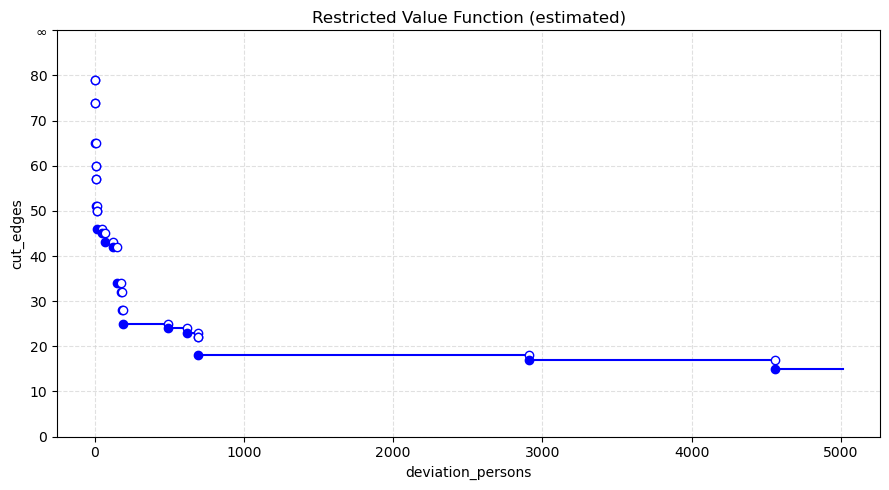

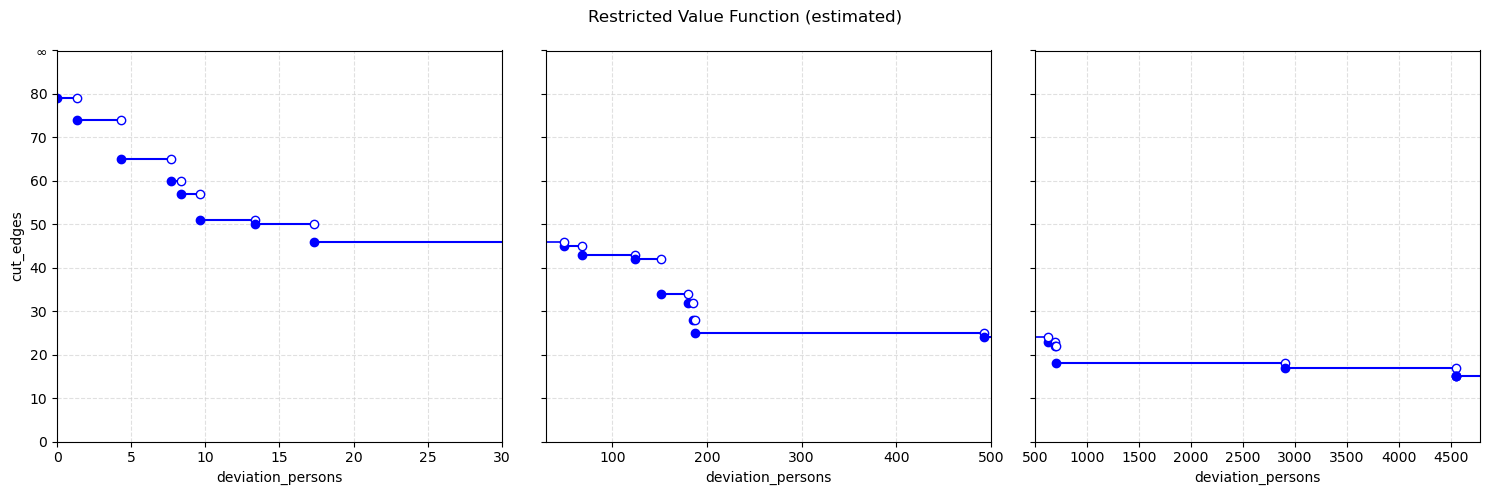

In [18]:
from pareto import ParetoFrontier

print(f"\n{'#' * 100}\nPareto Frontier for state {state},  objective {obj_type}\n{'#' * 100}\n")
pareto = ParetoFrontier(senses, obj_names, state=state, level='county')

if not  plans:
    print("No plan found!")
else:
    for plan, obj_bound, dev in result:
        upper_bound = [dev,  1/obj_bound[0] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[0]]
        lower_bound = [dev,  1/obj_bound[1] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[1]]
            
        # Add the plan and its objective values to the Pareto frontier
        pareto.add_plan(plan, upper_bound, lower_bound)
            
# Print the Pareto frontier plans and objective values
print("Pareto front plans:", pareto.plans)
print("Pareto front upper bounds:", pareto.upper_bounds)
print("Pareto front lower bounds:", pareto.lower_bounds)
    
#extra_points: list of tuples, each containing (deviation, objective_value, label)
if state == 'WV' and year ==2010:
    
    #2010 enacted map scores
    enacted_map_deviation = 3197.333333333372
    enacted_map_scores = {'inverse_Polsby_Popper': 7.75, 'cut_edges': 34.00, 
                                      'perimeter': 42.12, 'average_Polsby_Popper': 0.14,'bottleneck_Polsby_Popper': 0.10}
    # Cooper plan 1
    Cooper_plan_1_deviation = 323.66666666662786
    Cooper_plan_1_scores = {'inverse_Polsby_Popper': 7.31, 'cut_edges': 34.00, 
                                      'perimeter': 40.53, 'average_Polsby_Popper': 0.17,'bottleneck_Polsby_Popper': 0.10}
    # Cooper plan 2
    Cooper_plan_2_deviation = 232.66666666662786
    Cooper_plan_2_scores = {'inverse_Polsby_Popper': 8.18, 'cut_edges': 36.00, 
                                      'perimeter': 43.36, 'average_Polsby_Popper': 0.16,'bottleneck_Polsby_Popper': 0.09}
    # Cooper plan 3
    Cooper_plan_3_deviation = 115.66666666662786
    Cooper_plan_3_scores = {'inverse_Polsby_Popper': 7.25, 'cut_edges': 35.00, 
                                      'perimeter': 40.65, 'average_Polsby_Popper': 0.16,'bottleneck_Polsby_Popper': 0.09}
    extra_points = [
                (enacted_map_deviation,  enacted_map_scores[obj_type], 'Enacted Map'),
                (Cooper_plan_1_deviation,  Cooper_plan_1_scores[obj_type] , 'Cooper plan 1'),
                (Cooper_plan_2_deviation,  Cooper_plan_2_scores[obj_type], 'Cooper plan 2'),
                (Cooper_plan_3_deviation, Cooper_plan_3_scores[obj_type], 'Cooper plan 3'),
                        ]
    
    #extra_colors: list of colors corresponding to the points in extra_points
    extra_colors = ['r', 'g', 'c', 'y']  # Red, Green, Cyan, Yellow for each of the extra points
    
    for ep in extra_points:
        print(f"The {ep[2]} has an objective value of {ep[1]} and a deviation of {ep[0]}.")
else:
    extra_points = None
    extra_colors = None
        
pareto.tighten_lower_bounds()
    
if infeasible_region != None:
        
    # Get the max values for setting the limits
    max_dev = max(upper_bound[0] for upper_bound in pareto.upper_bounds)
    max_ce = max(upper_bound[1] for upper_bound in pareto.upper_bounds)
    o1lim=[0, max_dev+100]
    o2lim=[0, max_ce*(1.1)]
else:
    o1lim = None
    o2lim = None
pareto.plot_with_custom_x_ranges(splits=None,o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region, extra_points=extra_points, extra_colors=extra_colors)
pareto.plot_with_custom_x_ranges(splits=[30,500],o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region, extra_points=extra_points, extra_colors=extra_colors)


####################################################################################################
Pareto maps for state NE,  objective cut_edges
####################################################################################################



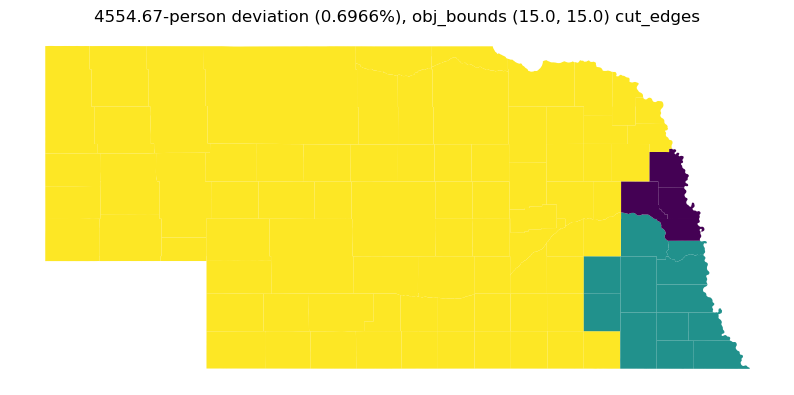

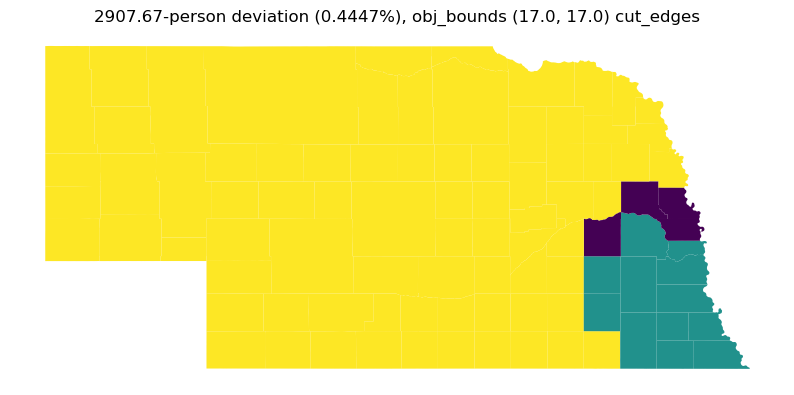

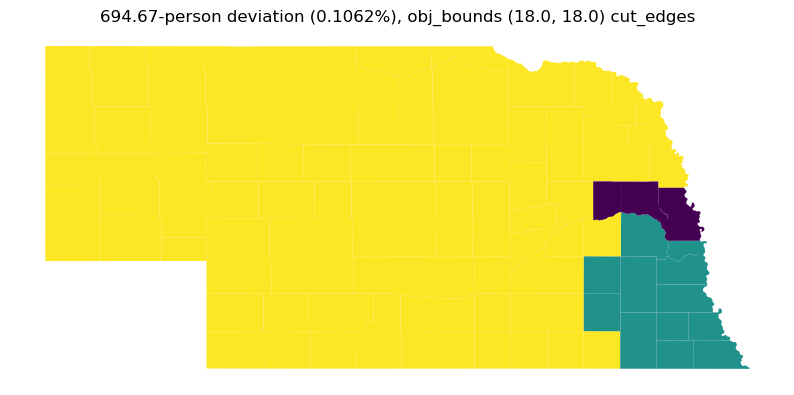

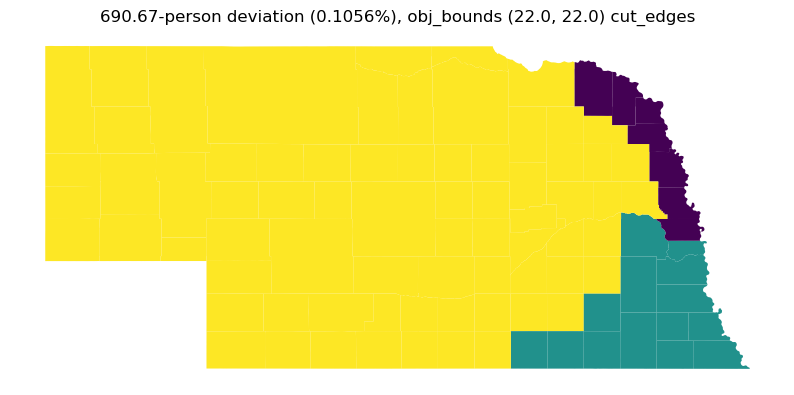

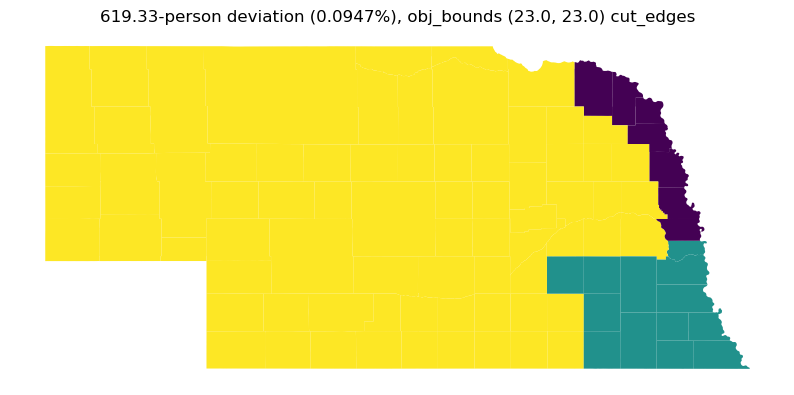

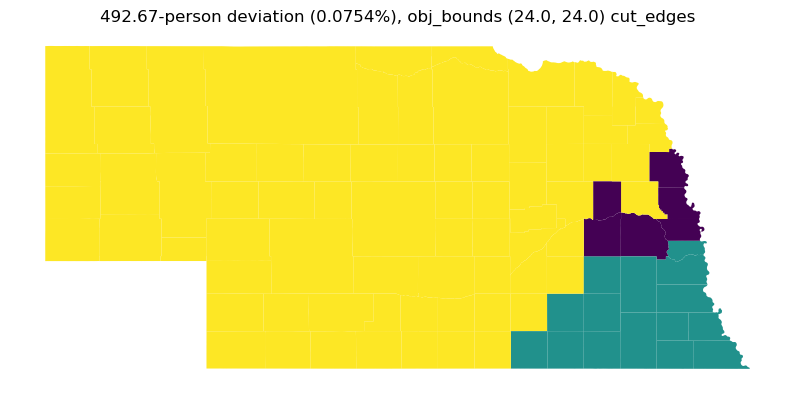

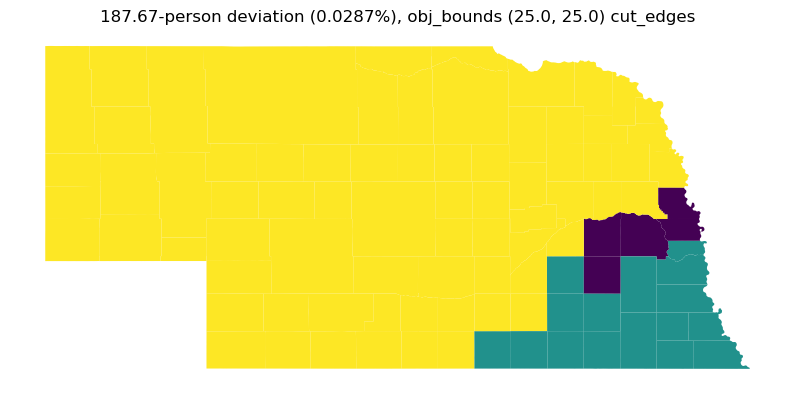

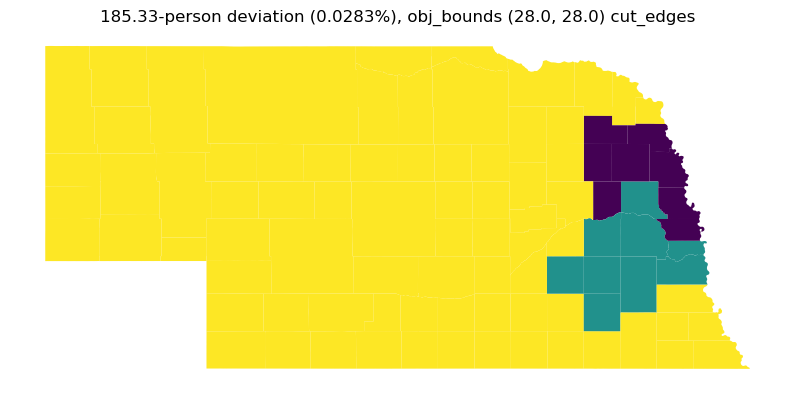

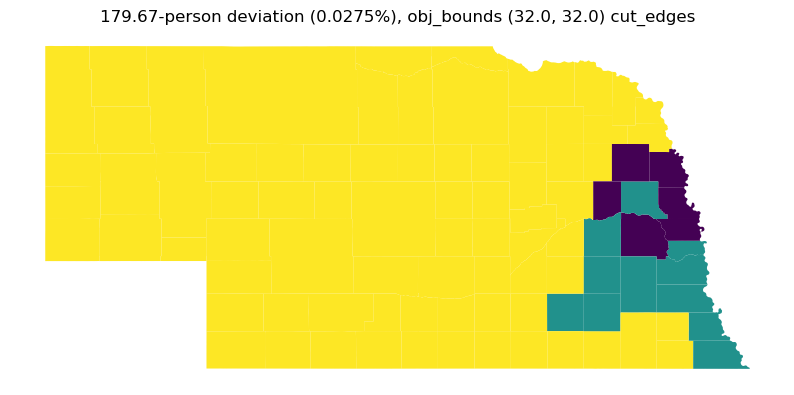

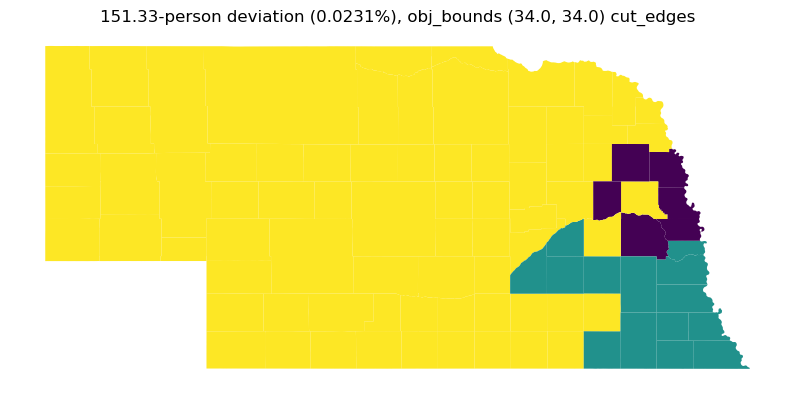

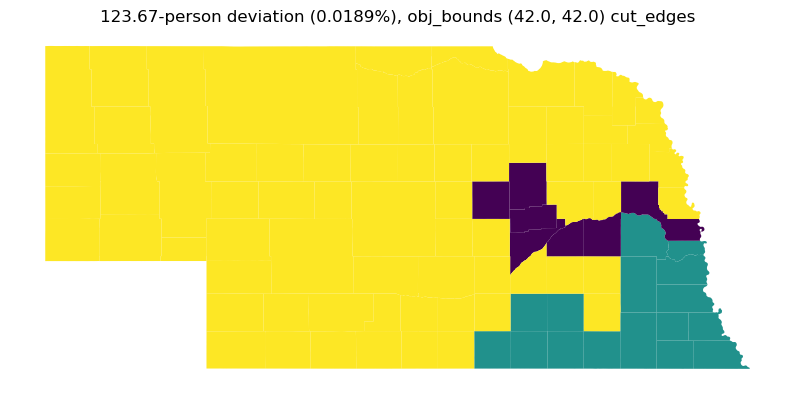

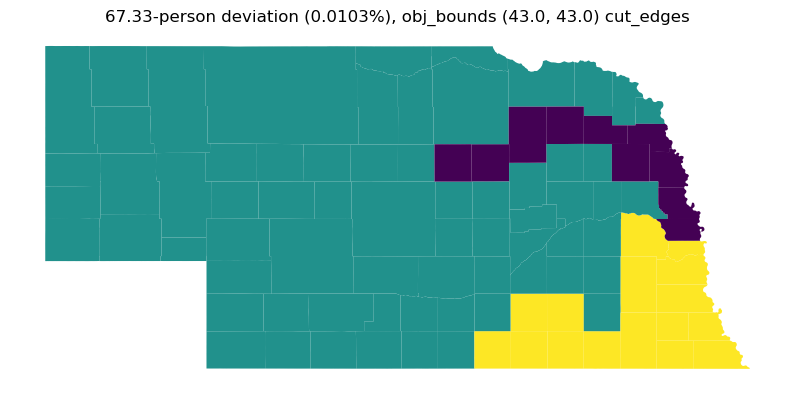

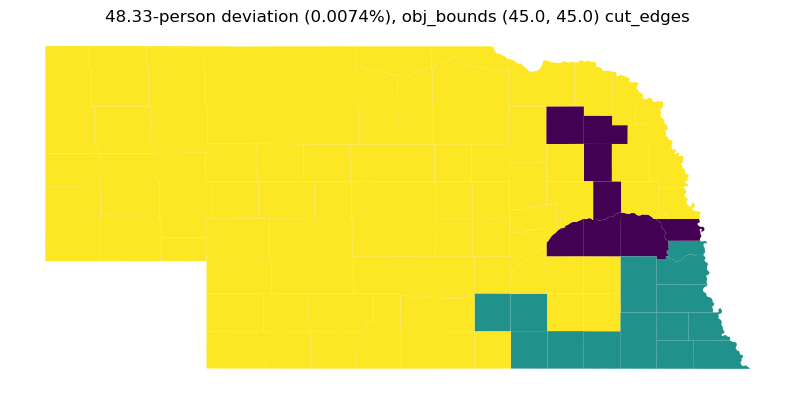

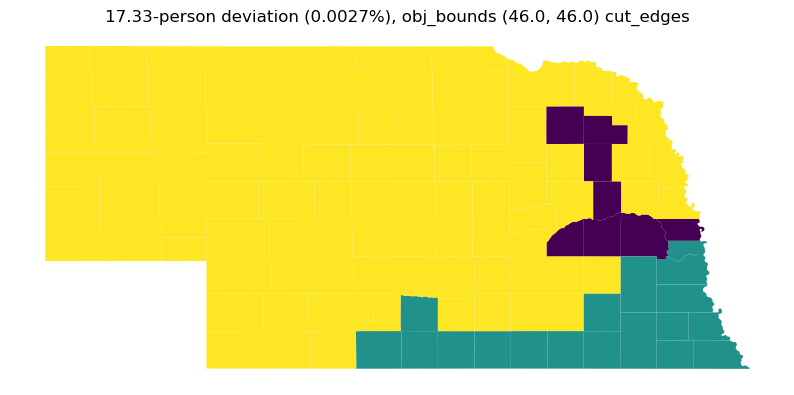

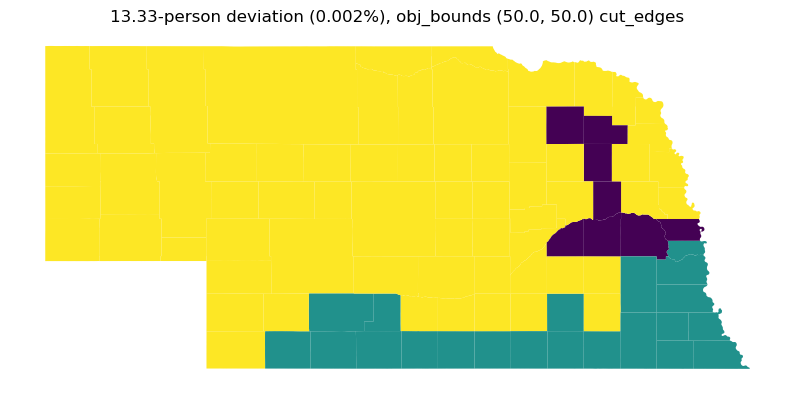

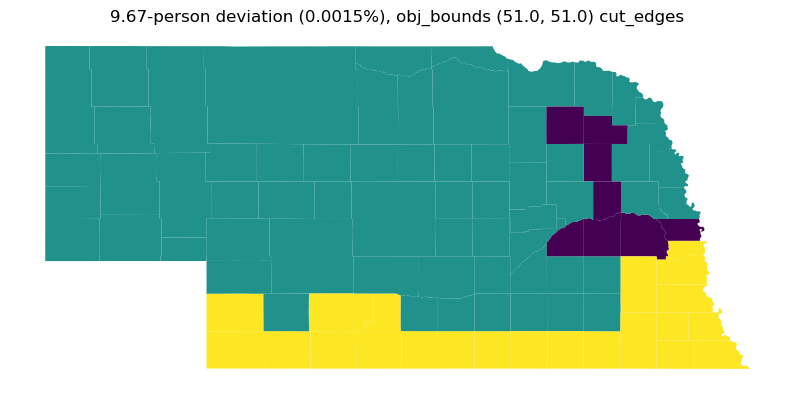

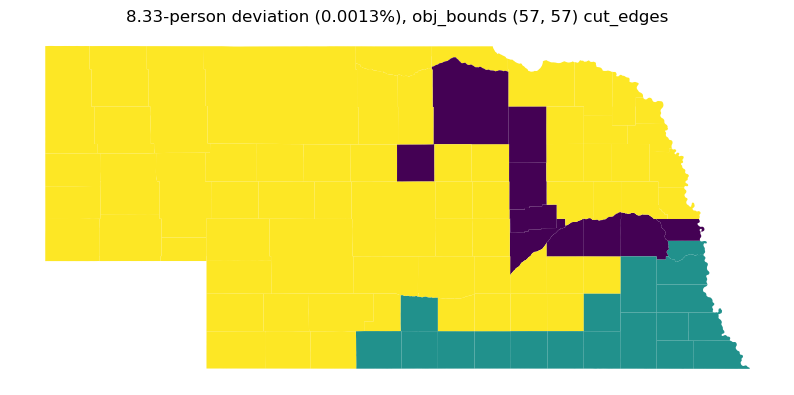

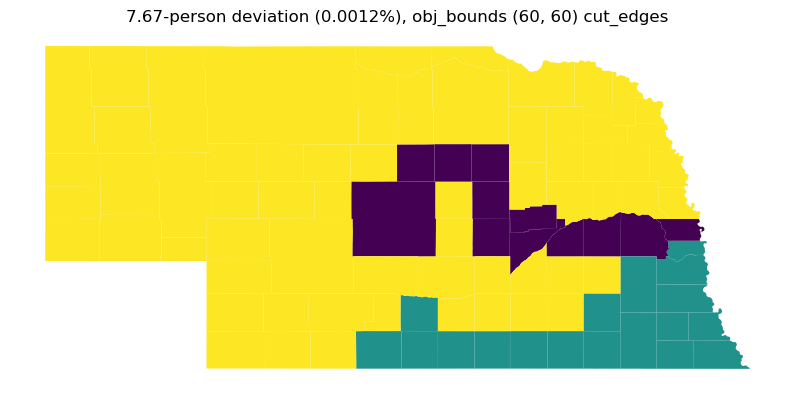

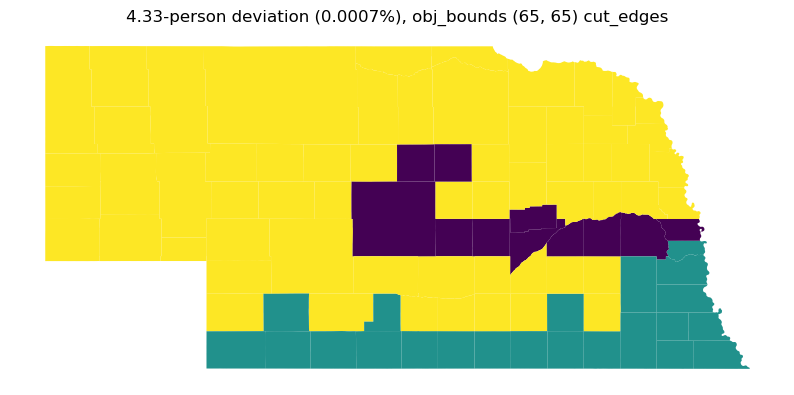

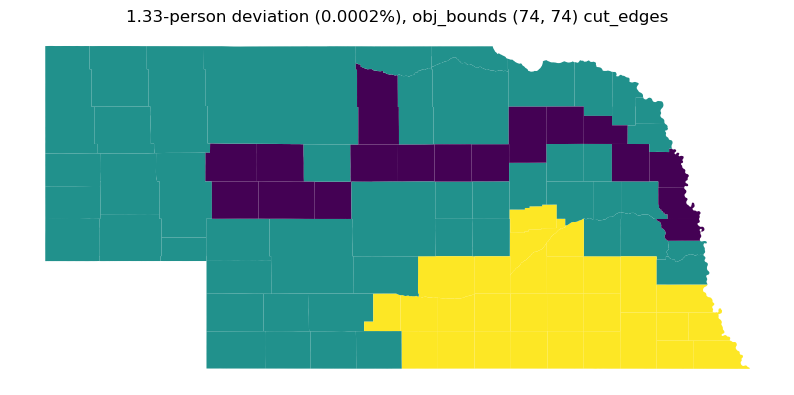

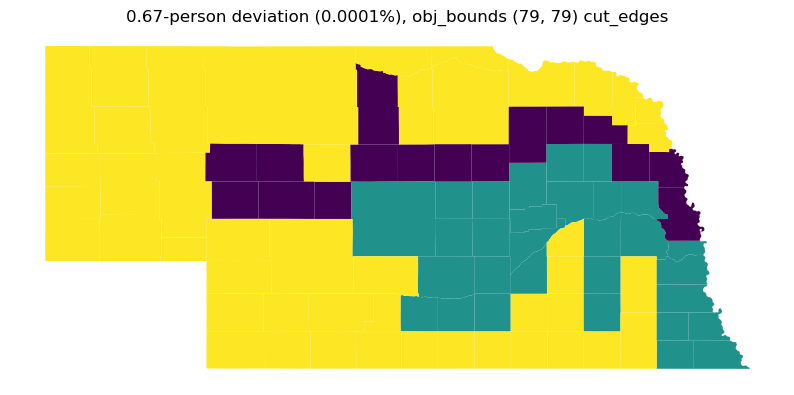

In [13]:
from draw import*

print(f"\n{'#' * 100}\nPareto maps for state {state},  objective {obj_type}\n{'#' * 100}\n")   
for plan, obj_bound, dev in result:
    title = f"{round(dev,2)}-person deviation ({round(100*dev/G._ideal_population,4)}%), obj_bounds {(round(obj_bound[0],2),round(obj_bound[1],2))} {obj_type}"
    draw_plan( filepath, filename2, G, plan, title=title, year=year )